In [548]:
import sys 
sys.path.append("../../")

# In[import libs]
import pandas as pd
import numpy as np
import os
import json
import seaborn as sns 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
from matplotlib.patches import Arc
from random import randint

from sklearn import metrics 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score,log_loss

from sklearn.calibration import CalibratedClassifierCV

from data_filters import scout_service as sct
from maths.pitch import calculate_shots_coordinates
from maths.trig import calculate_angles
from plots import plot_confusion_matrix,plot_sensitivity_vs_specificity

#from plots import *
from calls import get_jogos_sde

from prettytable import PrettyTable
import math
import time

import gatomestre_sde as sde

import warnings
warnings.filterwarnings("ignore")

In [549]:
# Retorna informações dos atletas
def get_atletas_sde(atleta_id):
    url = f'/atletas/{atleta_id}'
    try:
        response = sde._request_sde(url, False)
    except:
        url = f'/tecnicos/{atleta_id}'
        try:
            response = sde._request_sde(url, False)
        except:
            return None
    df = pd.DataFrame.from_dict(response).T
    df = sde.pivot_column(df, 'posicao')
    return df

In [550]:
def atualiza_informacoes_atleta(df):
    df_atletas = pd.DataFrame()
    for atleta_id in df['atleta_id'].unique():
        result = get_atletas_sde(int(atleta_id))
        df_atletas = pd.concat([df_atletas, result]).reset_index(drop=True)
    resultado = df.merge(df_atletas, how='left', on='atleta_id')
    return resultado

## Dataset

Dataset é coletado a partir de dados do Scout Service, referentes aos torneios no último biênio (2020/2021):

<code>
torneios = ['AmistososSelecao', 'Baiano', 'Brasileiro', 'BrasileiroB', 'BrasileiroFeminino', 'Carioca', 'CopaAmerica', 
            'CopaBrasil', 'CopaNordeste', 'CopaSPJunior', 'EliminatoriasCopaMundo', 'EuroCopa', 'Gaucho', 'Libertadores', 
            'Mineiro', 'OlimpiadasFutebolFeminino', 'OlimpiadasFutebolMasculino', 'Paulista', 'Pernambucano', 'PreLibertadores', 
            'RecopaSulAmericana', 'SulAmericana', 'SuperCopaBrasil']</code>

### Perguntas

* Porque o Events_ALL.gz tem a coluna index?
* Porque tem tantos valores duplicados da mesma jogada?
* Porque usou o head(100) nos dfs df_HS_predictor e df_HS_response?

In [551]:
# In[Running]
raw = pd.read_csv('database/2024/scout_service/events/Eventos_All.gz',compression='gzip', low_memory=False)
#df.isnull().sum()
# lidar com Nan
raw = raw.fillna(0)
# # limpar colunas
#del raw['index']
#del raw['Unnamed: 0']
# dados que precisam ser type <int>
raw = raw.astype({'PosicaoLance': 'int32', 'TempoPartida': 'int32', 'Jogador_Posicao': 'int32', 'atleta_id': 'int32', 'Rodada': 'int32','Codigo':'int32', 'clube_id':'int32','oponente_id':'int32'})
# eliminar lances inexistentes no dataframe
raw = raw[raw['PosicaoLance']!=-1]
#raw.info()

In [552]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2647333 entries, 3330383 to 6271065
Data columns (total 30 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Data                   object 
 1   DataRodada             object 
 2   Codigo                 int32  
 3   Lance                  object 
 4   Nome                   object 
 5   Ocorrencia             object 
 6   PosicaoLance           int32  
 7   TempoPartida           int32  
 8   TimestampStr           object 
 9   atleta_id              int32  
 10  apelido                object 
 11  sigla                  object 
 12  Jogador_Posicao        int32  
 13  Partida_CodigoExterno  int64  
 14  CampoPosicaoX          object 
 15  CampoPosicaoY          object 
 16  ContraAtaque           int64  
 17  Metros                 float64
 18  TravePosicaoX          object 
 19  TravePosicaoY          object 
 20  tempo                  object 
 21  tempo_2                object 
 22  clube_id    

In [553]:
raw

,Data,DataRodada,Codigo,Lance,Nome,Ocorrencia,PosicaoLance,TempoPartida,TimestampStr,atleta_id,...,tempo,tempo_2,clube_id,Codigo_SCT,Partida_CodigoInterno,Rodada,Torneio,Edicao,oponente_id,home_dummy
3330383,2023-04-05,2023-04-05T00:00:00,74,Passe,Completo,PT7S,22,1,2023-04-04T19:03:46,114802,...,00:07,19:03:46,293,74,15181,1,Libertadores,2023,290,1
3330384,2023-04-05,2023-04-05T00:00:00,74,Passe,Completo,PT9S,17,1,2023-04-04T19:00:22,98022,...,00:09,19:00:22,293,74,15181,1,Libertadores,2023,290,1
3330385,2023-04-05,2023-04-05T00:00:00,74,Passe,Completo,PT10S,11,1,2023-04-04T19:00:26,91866,...,00:10,19:00:26,293,74,15181,1,Libertadores,2023,290,1
3330386,2023-04-05,2023-04-05T00:00:00,74,Passe,Completo,PT13S,8,1,2023-04-04T19:00:28,38394,...,00:13,19:00:28,293,74,15181,1,Libertadores,2023,290,1
3330387,2023-04-05,2023-04-05T00:00:00,74,Passe,Completo,PT15S,4,1,2023-04-04T19:00:29,105208,...,00:15,19:00:29,293,74,15181,1,Libertadores,2023,290,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6271061,2024-05-30,2024-05-30T00:00:00,102,Não Encontrado,Perda de Posse de Bola,PT49M44S,36,2,2024-05-30T22:53:58,89275,...,49:44,22:53:58,283,102,21923,6,SulAmericana,2024,373,0
6271062,2024-05-30,2024-05-30T00:00:00,74,Passe,Completo,PT49M51S,7,2,2024-05-30T22:54:05,117824,...,49:51,22:54:05,2550,74,21923,6,SulAmericana,2024,0,0
6271063,2024-05-30,2024-05-30T00:00:00,74,Passe,Completo,PT49M53S,9,2,2024-05-30T22:54:07,132394,...,49:53,22:54:07,2550,74,21923,6,SulAmericana,2024,0,0
6271064,2024-05-30,2024-05-30T00:00:00,74,Passe,Completo,PT49M55S,11,2,2024-05-30T22:54:10,103385,...,49:55,22:54:10,2550,74,21923,6,SulAmericana,2024,0,0


In [554]:
# # Define the key columns that uniquely identify an event
# key_columns = ['TimestampStr', 'atleta_id', 'Codigo', 'PosicaoLance', 'TempoPartida']

# # Checking for duplicates based on these key columns
# duplicates = raw.duplicated(subset=key_columns, keep=False)

# # Inspecting how many duplicates are found
# num_duplicates = duplicates.sum()

# # Removing the duplicates
# raw_cleaned = raw[~duplicates].reset_index(drop=True)

# num_duplicates, raw_cleaned.shape


In [555]:
# padronizar colunas de acordo com pipeline cartola FC
raw = raw.rename(columns={'Jogador_Posicao':'posicao_id',
                         'Rodada':'rodada_id',
                         'oponente_id':'adversario_id',
                         'Partida_CodigoExterno': 'match_id',
                         'Partida_CodigoInterno':'match_id_sct'})

# o dataset contém muitos lances duplicados ,por isso precisamos dropar todos os que forem duplicados, mantendo somente a primeira aparição.
raw = raw.drop_duplicates(keep='last').reset_index(drop=True)
# print(raw.info())

In [556]:
# Convert position columns to numeric, setting errors='coerce' to turn non-convertible values into NaN
raw['TravePosicaoX'] = pd.to_numeric(raw['TravePosicaoX'], errors='coerce')
raw['TravePosicaoY'] = pd.to_numeric(raw['TravePosicaoY'], errors='coerce')
raw['CampoPosicaoX'] = pd.to_numeric(raw['CampoPosicaoX'], errors='coerce')
raw['CampoPosicaoY'] = pd.to_numeric(raw['CampoPosicaoY'], errors='coerce')

# You may want to fill NaN values with a default or use them in calculations as is
# Example: raw[['TravePosicaoX', 'TravePosicaoY', 'CampoPosicaoX', 'CampoPosicaoY']] = raw[['TravePosicaoX', 'TravePosicaoY', 'CampoPosicaoX', 'CampoPosicaoY']].fillna(0)


In [557]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2135724 entries, 0 to 2135723
Data columns (total 30 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Data           object 
 1   DataRodada     object 
 2   Codigo         int32  
 3   Lance          object 
 4   Nome           object 
 5   Ocorrencia     object 
 6   PosicaoLance   int32  
 7   TempoPartida   int32  
 8   TimestampStr   object 
 9   atleta_id      int32  
 10  apelido        object 
 11  sigla          object 
 12  posicao_id     int32  
 13  match_id       int64  
 14  CampoPosicaoX  float64
 15  CampoPosicaoY  float64
 16  ContraAtaque   int64  
 17  Metros         float64
 18  TravePosicaoX  int64  
 19  TravePosicaoY  int64  
 20  tempo          object 
 21  tempo_2        object 
 22  clube_id       int32  
 23  Codigo_SCT     int64  
 24  match_id_sct   int64  
 25  rodada_id      int32  
 26  Torneio        object 
 27  Edicao         int64  
 28  adversario_id  int32  
 29  home_dummy    

## Coordenadas

- Mapear coordenadas de (x,y) no campo e no gol de px para metros
- Calcular o ângulo (degrees e radians) da coordenada (x,y) em relação ao gol


## Nomemclatura

- goal_x_px, goal_y_px -> coordenadas (x,y) em px, para on local onde a finalização foi no gol
- field_x_px, field_y_px -> coordenadas (x,y) em px, para on local onde a finalização foi no gol
- goal_x_metros, goal_y_metros -> coordenadas (x,y) em metros, para para o local onde foi feita a finalização
- field_x_metros, field_y_metros -> coordenadas (x,y) em metros, para o local onde foi feita a finalização

# xG, xGOT, xA, XPre

- xG (expectaitva de gols)
- xGOT (expectaitva de gols on target)
- xA (expectaitva de assistências)
- xPre (expectaitva de pre assistência)

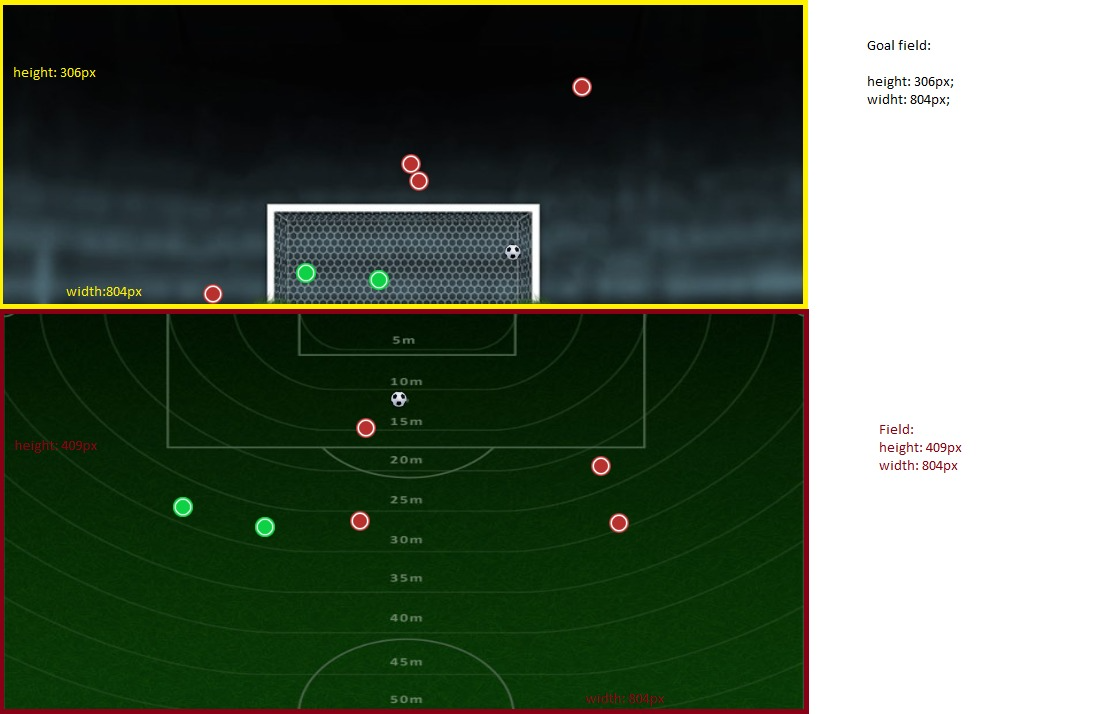

In [8]:
%matplotlib inline
from IPython.display import Image
Image('img/fields.png')

In [558]:
# filtragem por finalizações
df_finalizacoes = calculate_shots_coordinates(raw,'xG')
df_finalizacoes.to_csv('Finalizacoes.csv')
print(df_finalizacoes, df_finalizacoes.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49200 entries, 35 to 2135695
Data columns (total 45 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Data                       49200 non-null  object 
 1   DataRodada                 49200 non-null  object 
 2   Codigo                     49200 non-null  int64  
 3   Lance                      49200 non-null  object 
 4   Nome                       49200 non-null  object 
 5   Ocorrencia                 49200 non-null  object 
 6   PosicaoLance               49200 non-null  int64  
 7   TempoPartida               49200 non-null  int64  
 8   TimestampStr               49200 non-null  object 
 9   atleta_id                  49200 non-null  int64  
 10  apelido                    49200 non-null  object 
 11  sigla                      49200 non-null  object 
 12  posicao_id                 49200 non-null  int64  
 13  match_id                   49200 non-null  

In [559]:
print ("Rows     : " ,df_finalizacoes.shape[0])
print ("Columns  : " ,df_finalizacoes.shape[1])
print ("\nFeatures : \n" ,df_finalizacoes.columns.tolist())
print ("\nUnique values :  \n",df_finalizacoes.nunique())
print ("\nMissing values :  ", df_finalizacoes.isnull().sum().values.sum())

Rows     :  49200
Columns  :  45

Features : 
 ['Data', 'DataRodada', 'Codigo', 'Lance', 'Nome', 'Ocorrencia', 'PosicaoLance', 'TempoPartida', 'TimestampStr', 'atleta_id', 'apelido', 'sigla', 'posicao_id', 'match_id', 'CampoPosicaoX', 'CampoPosicaoY', 'ContraAtaque', 'Metros', 'TravePosicaoX', 'TravePosicaoY', 'tempo', 'tempo_2', 'clube_id', 'Codigo_SCT', 'match_id_sct', 'rodada_id', 'Torneio', 'Edicao', 'adversario_id', 'home_dummy', 'Goal', 'header', 'goal_x_px', 'goal_y_px', 'field_x_px', 'field_y_px', 'goal_x_metros', 'goal_y_metros', 'field_x_metros', 'field_y_metros', 'Center_dist', 'xG_angle_radians', 'xG_angle_degrees', 'xG_vertical_angle_radians', 'xG_vertical_angle_degrees']

Unique values :  
 Data                           280
DataRodada                     347
Codigo                          25
Lance                            4
Nome                            21
Ocorrencia                    3348
PosicaoLance                    34
TempoPartida                     5
Timest

In [560]:
# Convert 'TimestampStr' column to datetime
df_finalizacoes['Timestamp'] = pd.to_datetime(df_finalizacoes['TimestampStr'])
df_finalizacoes['year'] = df_finalizacoes['Timestamp'].dt.year
df_finalizacoes['month'] = df_finalizacoes['Timestamp'].dt.month
df_finalizacoes['day'] = df_finalizacoes['Timestamp'].dt.day

In [561]:
df_finalizacoes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49200 entries, 35 to 2135695
Data columns (total 49 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Data                       49200 non-null  object        
 1   DataRodada                 49200 non-null  object        
 2   Codigo                     49200 non-null  int64         
 3   Lance                      49200 non-null  object        
 4   Nome                       49200 non-null  object        
 5   Ocorrencia                 49200 non-null  object        
 6   PosicaoLance               49200 non-null  int64         
 7   TempoPartida               49200 non-null  int64         
 8   TimestampStr               49200 non-null  object        
 9   atleta_id                  49200 non-null  int64         
 10  apelido                    49200 non-null  object        
 11  sigla                      49200 non-null  object        
 12  p

In [562]:
print(set(df_finalizacoes['Torneio']))


{'CopaBrasil', 'BrasileiroB', 'Libertadores', 'SulAmericana', 'SuperCopaBrasil', 'Carioca', 'Brasileiro', 'Gaucho', 'Mineiro', 'PreLibertadores', 'Baiano', 'Paulista', 'Pernambucano', 'CopaNordeste', 'RecopaSulAmericana'}


### Fazer um recorte do dataframe após o início do provimento dos novos dados do Scout Service

Dados com 0.0 e -1 são faltantes

In [563]:
columns_to_check = ['goal_x_px', 'goal_y_px', 'field_x_px', 'field_y_px']
# Filter rows where all specified columns are not zero
df_finalizacoes = df_finalizacoes[~(df_finalizacoes[columns_to_check] == 0.0).all(axis=1)]

columns_to_check = ['Metros', 'Center_dist']
# Filter rows where all specified columns are not zero
df_finalizacoes = df_finalizacoes[~(df_finalizacoes[columns_to_check] == -1).all(axis=1)]

print(df_finalizacoes)


               Data           DataRodada  Codigo               Lance  \
121975   2023-11-04  2023-11-04T00:00:00       8  Finalização Cabeça   
121994   2023-11-04  2023-11-04T00:00:00      13         Finalização   
122086   2023-11-04  2023-11-04T00:00:00      24         Finalização   
122246   2023-11-04  2023-11-04T00:00:00      18  Finalização Cabeça   
122267   2023-11-04  2023-11-04T00:00:00      11         Finalização   
...             ...                  ...     ...                 ...   
2135606  2024-05-30  2024-05-30T00:00:00      11         Finalização   
2135639  2024-05-30  2024-05-30T00:00:00      13         Finalização   
2135675  2024-05-30  2024-05-30T00:00:00       8  Finalização Cabeça   
2135684  2024-05-30  2024-05-30T00:00:00      10         Finalização   
2135695  2024-05-30  2024-05-30T00:00:00      24         Finalização   

                           Nome Ocorrencia  PosicaoLance  TempoPartida  \
121975    Grande Área Defendido   PT13M31S            34     

In [564]:
print(df_finalizacoes[['Center_dist','Metros']])

         Center_dist  Metros
121975          10.0    10.0
121994          20.0    20.0
122086          25.0    25.0
122246          10.0    10.0
122267          15.0    15.0
...              ...     ...
2135606          5.0     5.0
2135639         30.0    30.0
2135675         15.0    15.0
2135684         15.0    15.0
2135695         25.0    25.0

[23554 rows x 2 columns]


In [565]:
print(set(df_finalizacoes['Torneio']))
#df_finalizacoes.loc[(df_finalizacoes['Torneio']=='Brasileiro')&(df_finalizacoes['Edicao']==2022)&(df_finalizacoes['Rodada']==34)]
print(set(df_finalizacoes[df_finalizacoes['Torneio']=='Brasileiro']['Edicao']))


{'CopaBrasil', 'BrasileiroB', 'Libertadores', 'SulAmericana', 'SuperCopaBrasil', 'Carioca', 'Brasileiro', 'Gaucho', 'Mineiro', 'PreLibertadores', 'Baiano', 'Paulista', 'Pernambucano', 'CopaNordeste'}
{2024, 2023}


## Visualização Preliminar das Finalizações

In [566]:
#plot_distribution(df_finalizacoes)

In [567]:
#plot_violin_plot(df_finalizacoes)

In [568]:
# # removendo linhas com valores ausentes 
# df_finalizacoes = df_finalizacoes.dropna()
# #df = df.drop(columns = ['x','y','Center_dis'])

# #convertendo as colunas 'header' e 'Goal' para valores numéricos
# df_finalizacoes['header'] = pd.to_numeric(df_finalizacoes['header'])
# df_finalizacoes['Goal'] = pd.to_numeric(df_finalizacoes['Goal'])

In [126]:
# # removendo linhas com valores ausentes 
# df_finalizacoes = df_finalizacoes.dropna()
# #df = df.drop(columns = ['x','y','Center_dis'])

# #convertendo as colunas 'header' e 'Goal' para valores numéricos
# df_finalizacoes['header'] = pd.to_numeric(df_finalizacoes['header'])
# df_finalizacoes['Goal'] = pd.to_numeric(df_finalizacoes['Goal'])
    
# #choose specific goals and misses

# #Selecionando índices onde houve um gol (Goal==1) e a distância é menor que 12 unidades.
# idx_goal = np.where((df_finalizacoes['Goal']==1) & (df_finalizacoes['Metros'] < 12)) 

# # criando um novo DataFrame df_HS_goal contendo as linhas selecionadas de acordo com idx_goal.
# df_HS_goal = df_finalizacoes.iloc[idx_goal]

# # selecionando índices onde não houve gol (Goal==0) e a distância é maior que 13 unidades.
# idx_miss = np.where((df_finalizacoes['Goal']==0) & (df_finalizacoes['Metros']> 13)) 

# #riando um novo DataFrame df_HS_miss contendo as linhas selecionadas de acordo com idx_miss
# df_HS_miss = df_finalizacoes.iloc[idx_miss]


# #criando arrays numpy contendo os valores de distância e gol/marcador para os casos de gol e não gol. Parece que você está preparando esses dados para usar em algum tipo de análise ou plotagem posterior.
# #plot the heaviside function on top of the responses for the seperable data above
# #df_HS_predictor = np.append(df_HS_goal['Distance'].head(100), df_HS_miss['Distance'].head(100))
# #df_HS_response = np.append(df_HS_goal['Goal'].head(100), df_HS_miss['Goal'].head(100))

In [21]:
#df_HS_goal

In [22]:
#plot_heavside(df_HS_goal,df_HS_miss)

In [23]:
#plot_shots()

In [24]:

# #Encontrar os índices das linhas em que ocorreram gols (Goal==1) e a distância é menor que 25 unidades
# idx = np.where((df_finalizacoes['Goal']==1) & (df_finalizacoes['Metros'] < 25)) 

# #criando um novo DataFrame chamado df_log_goal que contém as linhas selecionadas com base nos índices obtidos anteriormente
# df_log_goal = df_finalizacoes.iloc[idx]

# #encontrar os índices das linhas em que não ocorreram gols (Goal==0) e a distância é maior que 5 unidades.
# idx = np.where((df_finalizacoes['Goal']==0) & (df_finalizacoes['Metros']> 5)) 

# #criando um novo DataFrame chamado df_log_miss que contém as linhas selecionadas com base nos novos índices obtidos.
# df_log_miss = df_finalizacoes.iloc[idx]

In [25]:
#plot_goal_miss(df_finalizacoes, df_log_goal, df_log_miss)

## O modelo xG

Nosso objetivo é criar um modelo para descrever com precisão nossos dados existentes da melhor forma possível e, eventualmente, prever eventos futuros. Antes de aplicar a regressão logística a todo o nosso conjunto de dados, devemos dividir nossos dados em conjuntos de treinamento e teste. O conjunto de treinamento serve aos dados sobre os quais construímos nosso modelo, e o conjunto de teste são os dados que usamos para avaliar o desempenho de nosso modelo. Ajustar os dados de treinamento à função logística produzirá coeficientes para nossos preditores (farei isso usando a biblioteca Scikit-learn em Python). Se começarmos ajustando apenas a variável de distância, devemos chegar aos parâmetros ideais para descrever os dados de treinamento:

## EDA - Exploratory Data Analysis

In [26]:
# df_finalizacoes_EDA = df_finalizacoes[['Goal','Metros','xG_angle_degrees','xG_vertical_angle_degrees', 'header', 'ContraAtaque']]
# df_finalizacoes_EDA.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16931 entries, 3452432 to 5460232
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Goal                       16931 non-null  int64  
 1   Metros                     16931 non-null  float64
 2   xG_angle_degrees           16931 non-null  float64
 3   xG_vertical_angle_degrees  16931 non-null  float64
 4   header                     16931 non-null  int64  
 5   ContraAtaque               16931 non-null  int64  
dtypes: float64(3), int64(3)
memory usage: 925.9 KB


In [27]:
# print ("Rows     : " ,df_finalizacoes_EDA.shape[0])
# print ("Columns  : " ,df_finalizacoes_EDA.shape[1])
# print ("\nFeatures : \n" ,df_finalizacoes_EDA.columns.tolist())
# print ("\nUnique values :  \n",df_finalizacoes_EDA.nunique())
# print ("\nMissing values :  ", df_finalizacoes_EDA.isnull().sum().values.sum())

Rows     :  16931
Columns  :  6

Features : 
 ['Goal', 'Metros', 'xG_angle_degrees', 'xG_vertical_angle_degrees', 'header', 'ContraAtaque']

Unique values :  
 Goal                             2
Metros                          10
xG_angle_degrees             13137
xG_vertical_angle_degrees     9068
header                           2
ContraAtaque                     2
dtype: int64

Missing values :   0


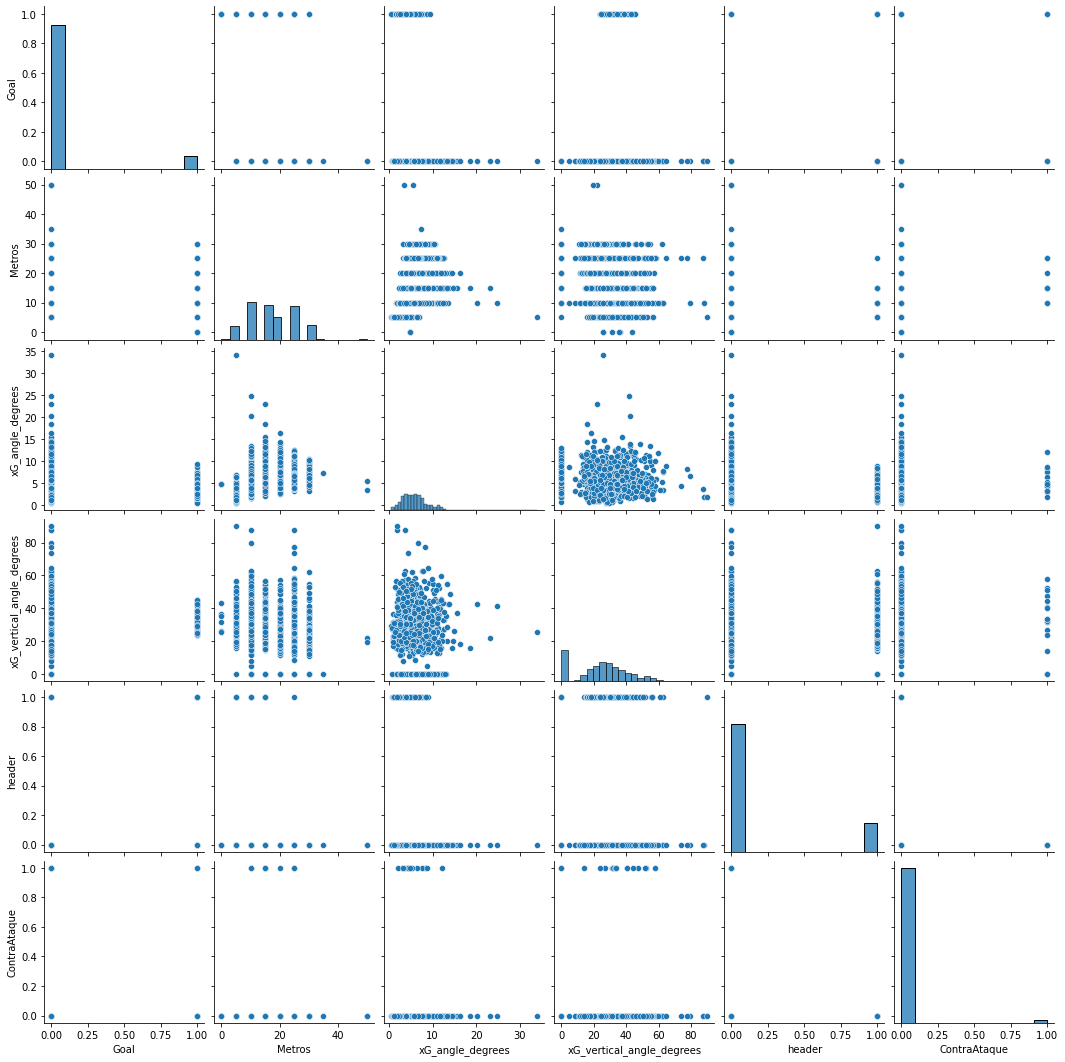

In [27]:
# sns.pairplot(df_finalizacoes_EDA)

<AxesSubplot:>

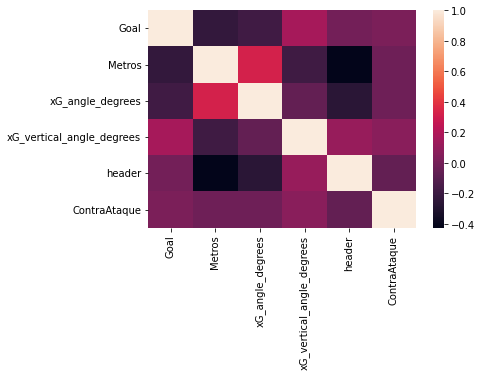

In [28]:
# sns.heatmap(df_finalizacoes_EDA.corr())

Text(0.5, 0, 'Metros')

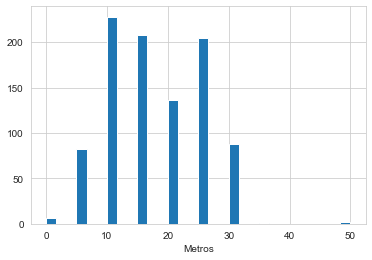

In [82]:
# sns.set_style('whitegrid')
# df_finalizacoes_EDA['Metros'].hist(bins=30)
# plt.xlabel('Metros')

Text(0.5, 0, 'xG_angle_degrees')

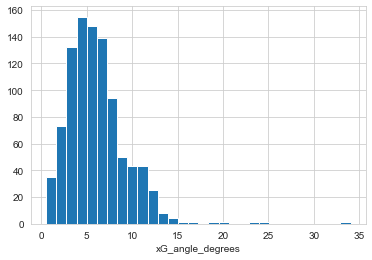

In [83]:
# sns.set_style('whitegrid')
# df_finalizacoes_EDA['xG_angle_degrees'].hist(bins=30)
# plt.xlabel('xG_angle_degrees')

Text(0.5, 0, 'xG_vertical_angle_degrees')

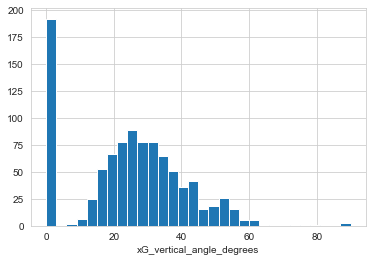

In [84]:
# sns.set_style('whitegrid')
# df_finalizacoes_EDA['xG_vertical_angle_degrees'].hist(bins=30)
# plt.xlabel('xG_vertical_angle_degrees')

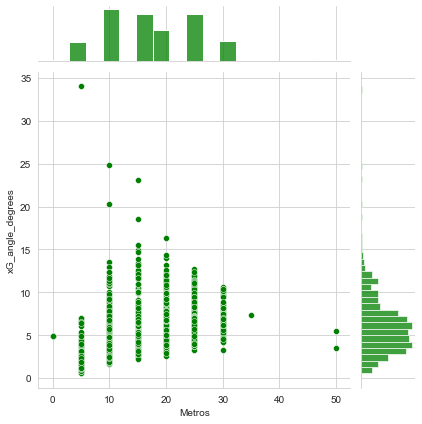

In [88]:
# sns.jointplot(x='Metros',y='xG_angle_degrees',data=df_finalizacoes_EDA,color='green');

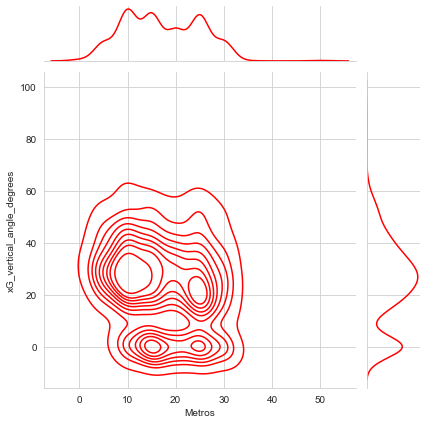

In [89]:
# sns.jointplot(x='Metros',y='xG_vertical_angle_degrees',data=df_finalizacoes_EDA,color='red',kind='kde');

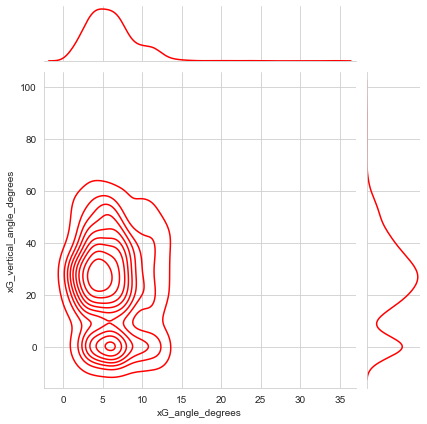

In [90]:
# sns.jointplot(x='xG_angle_degrees',y='xG_vertical_angle_degrees',data=df_finalizacoes_EDA,color='red',kind='kde');

### Estudo 1 - Distância do Chute

In [29]:
# #we are going to split the data into a test and train set(20% of it will go towards testing)
# #for now we are going to model just the distance predictor

# #Divisão dos dados:
# train_dis = df_finalizacoes[['Goal','Metros']].copy()

# #O conjunto de treinamento inclui a variável independente "Distance" e a variável dependente "Goal".
# x_train_dis, x_test_dis, y_train_dis, y_test_dis = train_test_split(train_dis.drop('Goal',axis=1), 
#                                                     train_dis['Goal'], test_size=0.20, 
#                                                     random_state=10)

# #Criação e treinamento do modelo de regressão logística:
# lgm_dis = LogisticRegression()
# lgm_dis.fit(x_train_dis,y_train_dis)

# #Obtendo os coeficientes do modelo:
# log_odds = lgm_dis.coef_[0]
# print(lgm_dis.coef_, lgm_dis.intercept_)

# #Apresentação dos coeficientes:
# pd.DataFrame(log_odds, 
#              x_train_dis.columns, 
#              columns=['coef']).sort_values(by='coef', ascending=False)


# #compare this model to the sample data from before

# #Comparação com os dados de exemplo:
# df_HS_predictor = np.append(df_log_goal['Metros'].head(100), df_log_miss['Metros'].head(100))
# df_HS_response = np.append(df_log_goal['Goal'].head(100), df_log_miss['Goal'].head(100))

[[-0.12165816]] [-0.66445698]


1. Coeficientes do Modelo:
* Coeficiente da variável "Distance": -0.12165816
* Intercepto: -0.66445698

Os coeficientes da regressão logística representam o impacto relativo de cada variável independente (preditora) na probabilidade de ocorrer o evento de interesse (no seu caso, marcar um gol, representado pela variável "Goal").

* Coeficiente da variável "Distance" (-0.12165816): Esse valor negativo indica que, mantendo as outras variáveis constantes, um aumento na distância do chute está associado a uma diminuição nas chances de marcar um gol. Ou seja, quanto maior a distância do chute, menor a probabilidade de marcar um gol.

* Intercepto (-0.66445698): O intercepto é o valor da probabilidade logit quando todas as outras variáveis independentes são iguais a zero. Neste caso, não tem uma interpretação direta em termos do domínio do problema, pois é uma probabilidade logit, que é uma transformação da probabilidade de sucesso (marcar um gol) usando a função logística.

### Estudo 2 - Ângulo do Chute

In [30]:
# #similar to before but using ang variable
# train_ang = df_finalizacoes[['Goal','xG_angle_degrees','xG_vertical_angle_degrees']].copy()
# x_train_ang, x_test_ang, y_train_ang, y_test_ang = train_test_split(train_ang.drop('Goal',axis=1), 
#                                                     train_ang['Goal'], test_size=0.20, 
#                                                     random_state=10)

# lgm_ang = LogisticRegression()
# lgm_ang.fit(x_train_ang,y_train_ang)
# log_odds_ang = lgm_ang.coef_[0]

# print(lgm_ang.coef_, lgm_ang.intercept_)

# pd.DataFrame(log_odds_ang, 
#              x_train_ang.columns, 
#              columns=['coef']).sort_values(by='coef', ascending=False)

[[-0.34575506  0.03968535]] [-1.85046492]


,coef
xG_vertical_angle_degrees,0.039685
xG_angle_degrees,-0.345755


### Estudo 3 - Distância e Ângulo do Chute

In [31]:
# train_2 = df_finalizacoes[['Goal','Metros','xG_angle_degrees','xG_vertical_angle_degrees']].copy()
# x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(train_2.drop('Goal',axis=1), 
#                                                         train_2['Goal'], test_size=0.20, 
#                                                         random_state=10)
        
# lgm_2 = LogisticRegression(random_state=0)
# lgm_2.fit(x_train_2,y_train_2)

# log_odds = lgm_2.coef_[0]

# print(lgm_2.coef_, lgm_2.intercept_)

# print(pd.DataFrame(log_odds, 
#              x_train_2.columns, 
#              columns=['coef']).sort_values(by='coef', ascending=False))


# def Logistic(Y):
#     g_y = 1 + np.exp(-Y)
#     return np.reciprocal(g_y)


# x0 = np.linspace(-34, 34, 100)
# x1 = np.linspace(.1, 53 , 100)
# x_0 = np.linspace(0, 68, 100)
# x0_grid, x1_grid = np.meshgrid(x0, x1)
# c=7.32
# a=np.sqrt((x0_grid-7.32/2)**2 + x1_grid**2)
# b=np.sqrt((x0_grid+7.32/2)**2 + x1_grid**2)

# h_grid = Logistic(lgm_2.coef_[0][1]*np.arccos((c**2-a**2-b**2)/(-2*a*b))
#                   +lgm_2.coef_[0][0]*np.sqrt((x1_grid)**2+(x0_grid)**2)+lgm_2.intercept_[0])

[[-0.06911238 -0.22522615  0.03767011]] [-1.38394358]
                               coef
xG_vertical_angle_degrees  0.037670
Metros                    -0.069112
xG_angle_degrees          -0.225226


## Avaliação do Modelo 

Se quisermos avaliar a precisão de nosso modelo, temos que testar quão bem ele pode prever eventos futuros. Mas isso levanta outra preocupação. Como classificamos uma finalização com nosso novo modelo de metas esperadas? Ao contrário da função Heaviside, que fornece classificações rígidas, o modelo de regressão logística retorna a probabilidade de um chute resultar em um gol.

Para fazer uma classificação, temos que definir um limite. Esse limite essencialmente divide a função logística, atribuindo metas para onde o modelo está acima do limite e falha abaixo. Por exemplo:

In [32]:
# plot logistic model with 3 different thresholds
# plot_logistic_regression_model_for_shots(df_log_goal,df_log_miss,lgm_dis,threshold=0.3,threshold_x=6.5)
# plot_logistic_regression_model_for_shots(df_log_goal,df_log_miss,lgm_dis,threshold=0.1,threshold_x=16)
# plot_logistic_regression_model_for_shots(df_log_goal,df_log_miss,lgm_dis,threshold=0.02,threshold_x=28)

In [33]:
# train_dis = df_finalizacoes[['Goal','Metros','xG_angle_degrees','xG_vertical_angle_degrees']].copy()

# #O conjunto de treinamento inclui a variável independente "Distance" e a variável dependente "Goal".
# x_train_dis, x_test_dis, y_train_dis, y_test_dis = train_test_split(train_dis.drop('Goal',axis=1), 
#                                                     train_dis['Goal'], test_size=0.20, 
#                                                     random_state=10)

# #Criação e treinamento do modelo de regressão logística:
# lgm_dis = LogisticRegression()
# lgm_dis.fit(x_train_dis,y_train_dis)

# #Obtendo os coeficientes do modelo:
# log_odds = lgm_dis.coef_[0]
# print(lgm_dis.coef_, lgm_dis.intercept_)

# #Apresentação dos coeficientes:
# pd.DataFrame(log_odds, 
#              x_train_dis.columns, 
#              columns=['coef']).sort_values(by='coef', ascending=False)


# #compare this model to the sample data from before

# #Comparação com os dados de exemplo:
# df_HS_predictor = np.append(df_log_goal['Metros'].head(100), df_log_miss['Metros'].head(100))
# df_HS_response = np.append(df_log_goal['Goal'].head(100), df_log_miss['Goal'].head(100))

[[-0.06911238 -0.22522615  0.03767011]] [-1.38394358]


[[169   6]
 [ 15   2]]
[[132  43]
 [  6  11]]
[[ 54 121]
 [  0  17]]


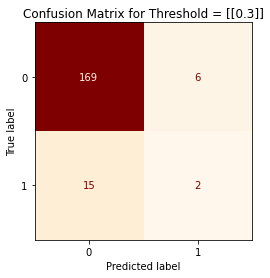

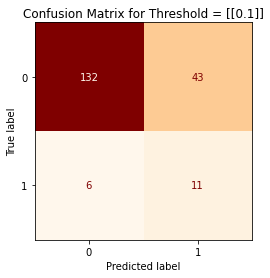

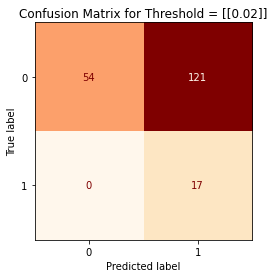

In [34]:
# # test confusion matrix with 3 thresholds
# cm_dis_03 = plot_confusion_matrix(lgm_dis,x_test_dis,y_test_dis,threshold=[0.3])
# cm_dis_01 = plot_confusion_matrix(lgm_dis,x_test_dis,y_test_dis,threshold=[0.1])
# cm_dis_002 = plot_confusion_matrix(lgm_dis,x_test_dis,y_test_dis,threshold=[0.02])

In [35]:
# sensitivity_3, specificity_3 = plot_sensitivity_vs_specificity(cm_dis_03,0.3)
# sensitivity_10, specificity_10 = plot_sensitivity_vs_specificity(cm_dis_01,0.1)
# sensitivity_02, specificity_02 = plot_sensitivity_vs_specificity(cm_dis_002,0.02)

sensitivity when threshold: 0.3 = 0.11764705882352941
specificity when threshold:0.3 = 0.9657142857142857
6
sensitivity when threshold: 0.1 = 0.6470588235294118
specificity when threshold:0.1 = 0.7542857142857143
43
sensitivity when threshold: 0.02 = 1.0
specificity when threshold:0.02 = 0.30857142857142855
121



Agora prevemos gols e erros em uma taxa mais equilibrada. Vimos que três limites diferentes produzem previsões muito diferentes de nosso modelo. Onde eles variam é em sua especificidade e sensibilidade; ou seja, sua capacidade de prever corretamente os gols e erros. É uma troca. Então, que limite escolhemos? Bem, nenhum deles e todos eles.

Vamos dar um passo para trás. Se estivéssemos usando um modelo de regressão logística para identificar se um paciente tem câncer, então adotaríamos um limite alto, para renunciar a uma alta taxa de especificidade em favor de uma alta sensibilidade. Preferimos dar resultados falsos positivos em vez de falsos negativos. Não queremos que alguém saia pensando que foi aprovado em um exame de câncer, quando na verdade ele tem câncer. Quando tentamos modelar a probabilidade do objetivo, não temos essa preferência. Na verdade, tentar prever metas diretamente não é tão útil para começar. Como veremos na próxima parte, o poder do modelo de gol esperado não está em fazer uma previsão para um único tiro. Então, qual foi o propósito de investigar limites e matrizes de confusão? Podemos usá-los para comparar diferentes modelos usando algo conhecido como gráfico Receiver Operator Characteristic (ROC).

Text(0.5, 1.0, 'ROC Graph')

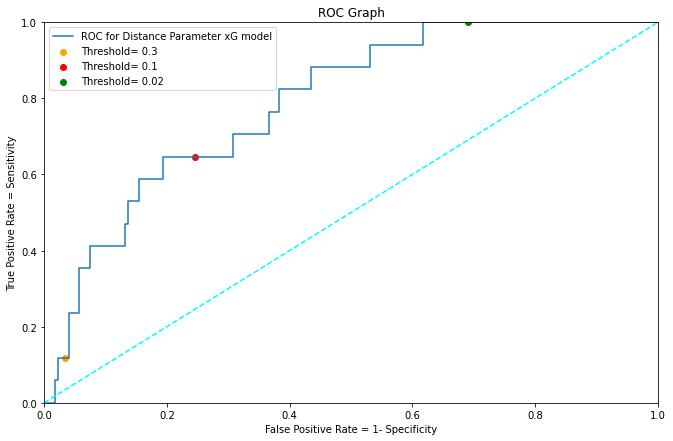

In [36]:
# fig, axes = plt.subplots(figsize=(11,7))
# y_score = lgm_dis.decision_function(x_test_dis)
# fpr, tpr, _  = roc_curve(y_test_dis,y_score, pos_label=lgm_dis.classes_[1])
# plt.plot(fpr,tpr,label='ROC for Distance Parameter xG model')

# plt.scatter(1-specificity_3,sensitivity_3,c='orange',label='Threshold= 0.3')
# plt.scatter(1-specificity_10,sensitivity_10,c='red',label='Threshold= 0.1')
# plt.scatter(1-specificity_02,sensitivity_02,c='green',label='Threshold= 0.02')
# y_45 = np.linspace(0,1,100) 
# plt.plot(y_45,y_45,linestyle='dashed',c='cyan')
# plt.legend()
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.xlabel('False Positive Rate = 1- Specificity')
# plt.ylabel('True Positive Rate = Sensitivity')
# plt.title('ROC Graph')

Usando um pequeno *step size*, a curva ROC representa a capacidade do modelo de prever as metas corretamente versus sua capacidade de prever incorretamente as perdas para diferentes valores de limite. Conforme você move para cima no eixo y, o modelo prevê melhor as metas, e conforme nos movemos para a esquerda ao longo do eixo x, o modelo prevê melhor os erros. Basicamente, ele mapeia o equilíbrio entre a previsão de metas e a previsão de erros. A linha tracejada representa um modelo que não tem poder preditivo e é essencialmente inútil porque para cada classificação correta, ela também prevê uma classificação incorreta. Portanto, quanto mais longe nossa curva ROC está da linha de 45 graus, melhor é o trabalho geral que ela realiza na classificação dos dados de teste. Outra maneira de ver isso é que quanto maior a área sob a curva, melhor será o nosso modelo para descrever os dados de teste. Isso é útil para nós porque podemos usá-lo para comparar modelos diferentes e ver se há alguma vantagem substancial em adicionar mais variáveis ​​ao nosso modelo.

In [37]:
# train_3 = df_finalizacoes[['Goal','Metros','xG_angle_degrees','xG_vertical_angle_degrees','header']].copy()
# x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(train_3.drop('Goal',axis=1), 
#                                                     train_3['Goal'], test_size=0.20, 
#                                                     random_state=10)
# lgm_3 = LogisticRegression()
# lgm_3.fit(x_train_3,y_train_3)
# log_odds = lgm_3.coef_[0]
# print(lgm_3.coef_, lgm_3.intercept_)

# train_4 = df_finalizacoes[['Goal','Metros','xG_angle_degrees','xG_vertical_angle_degrees','header','ContraAtaque']].copy()
# x_train_4, x_test_4, y_train_4, y_test_4 = train_test_split(train_4.drop('Goal',axis=1), 
#                                                     train_4['Goal'], test_size=0.20, 
#                                                     random_state=10)
# lgm_4 = LogisticRegression()
# lgm_4.fit(x_train_4,y_train_4)
# log_odds = lgm_4.coef_[0]
# print(lgm_4.coef_, lgm_4.intercept_)

[[-0.08855096 -0.23179629  0.03910843 -1.17341207]] [-0.88848324]
[[-0.08789357 -0.23399356  0.03967411 -1.184734   -0.39555806]] [-0.89388609]


Text(0.5, 1.0, 'ROC Graph')

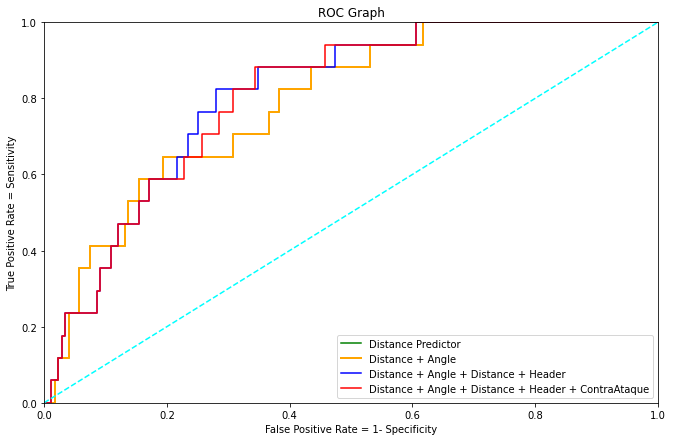

In [38]:
# fig, axes = plt.subplots(figsize=(11,7))

# y_score = lgm_dis.decision_function(x_test_dis)
# fpr, tpr, _  = roc_curve(y_test_dis,y_score, pos_label=lgm_dis.classes_[1])
# plt.plot(fpr,tpr,label='Distance Predictor',c='green')

# y_score_2 = lgm_2.decision_function(x_test_2)
# fpr2, tpr2, _  = roc_curve(y_test_2,y_score_2, pos_label=lgm_2.classes_[1])
# plt.plot(fpr2,tpr2,label='Distance + Angle',c='orange',linewidth=2)

# y_score_3 = lgm_3.decision_function(x_test_3)
# fpr_3, tpr_3, _  = roc_curve(y_test_3,y_score_3, pos_label=lgm_3.classes_[1])
# plt.plot(fpr_3,tpr_3,label='Distance + Angle + Distance + Header',c='blue')

# y_score_4 = lgm_4.decision_function(x_test_4)
# fpr_4, tpr_4, _  = roc_curve(y_test_4,y_score_4, pos_label=lgm_4.classes_[1])
# plt.plot(fpr_4,tpr_4,label='Distance + Angle + Distance + Header + ContraAtaque',c='red')
# plt.legend()


# y_45 = np.linspace(0,1,100) 
# plt.plot(y_45,y_45,linestyle='dashed',c='cyan')

# plt.xlim([0, 1])
# plt.ylim([0, 1])

# plt.xlabel('False Positive Rate = 1- Specificity')
# plt.ylabel('True Positive Rate = Sensitivity')
# plt.title('ROC Graph')

Agora temos algo concreto ao avaliar nosso modelo. Se olharmos de perto, um modelo com distância e ângulo como variáveis ​​de entrada produz a mesma área sob a curva (AUC) que o mesmo modelo, mas com um parâmetro de "distância ao centro" adicionado. Portanto, ao contrário de algumas das suposições que fizemos anteriormente, o preditor de “distância ao centro” não acrescenta muito ao desempenho de nosso modelo e devemos excluí-lo. Embora o parâmetro “distância até o centro” tenha mostrado uma ligeira mudança no modelo em áreas próximas à linha de gol, essa mudança significou muito pouco, já que poucos chutes são feitos a partir dessas posições. O AUC, portanto, nos diz que adicionar o centro à variável de distância é bastante inútil. Observe que poderíamos ter usado os valores p com a mesma facilidade para saber se o parâmetro centro para distância é útil para o nosso modelo.

Outra vantagem da curva ROC é que se optássemos por usar outras técnicas de classificação, como SVM, florestas aleatórias, redes neurais, etc., poderíamos comparar e contrastar o desempenho desses modelos com o que criamos aqui. Acho que isso é um exagero para o problema em questão, mas é um caminho para uma exploração mais aprofundada. Embora esses modelos alternativos produzam resultados semelhantes, a regressão logística nos fornece um método bastante simples e digerível para descrever os resultados das tomadas, ao passo que esses outros métodos requerem um entendimento mais profundo e sofisticado das técnicas de aprendizado de máquina.

## Escolha Preliminar: Regressão Logística
#### Vetores:
- Distância
- Ângulo
- Cabeçada

In [39]:
# train_5 = df_finalizacoes[['Goal','Metros','xG_angle_degrees','xG_vertical_angle_degrees','ContraAtaque','header']].copy()
# x_train_5, x_test_5, y_train_5, y_test_5 = train_test_split(train_5.drop('Goal',axis=1), 
#                                                     train_5['Goal'], test_size=0.20, 
#                                                     random_state=10)

# lgm_5 = LogisticRegression(fit_intercept=False,solver='lbfgs')
# lgm_5.fit(x_train_5,y_train_5)

# y_pred = lgm_5.predict_proba(x_test_5)[:,1]
# y_hat = lgm_5.predict_proba(train_5.drop('Goal',axis=1))[:,1]
# y_hat.shape

(956,)

Mais uma vez, testamos ROC neste modelo

In [63]:
# # test for best parameter model
# pred_proba_df = pd.DataFrame(lgm_5.predict_proba(x_test_5))
# # thresholds values
# threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]

# for i in threshold_list:
#     print ('\n******** For i = {} ******'.format(i))
#     Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
#     test_accuracy = metrics.accuracy_score(y_test_5.to_numpy().reshape(y_test_5.to_numpy().size,1),
#                                            Y_test_pred.iloc[:,1].to_numpy().reshape(Y_test_pred.iloc[:,1].to_numpy().size,1))
#     print('Our testing accuracy is {}'.format(test_accuracy))

#     print(confusion_matrix(y_test_5.to_numpy().reshape(y_test_5.to_numpy().size,1),
#                            Y_test_pred.iloc[:,1].to_numpy().reshape(Y_test_pred.iloc[:,1].to_numpy().size,1)))


******** For i = 0.05 ******
Our testing accuracy is 0.6822916666666666
[[117  58]
 [  3  14]]

******** For i = 0.1 ******
Our testing accuracy is 0.8020833333333334
[[144  31]
 [  7  10]]

******** For i = 0.15 ******
Our testing accuracy is 0.84375
[[154  21]
 [  9   8]]

******** For i = 0.2 ******
Our testing accuracy is 0.8645833333333334
[[159  16]
 [ 10   7]]

******** For i = 0.25 ******
Our testing accuracy is 0.8697916666666666
[[163  12]
 [ 13   4]]

******** For i = 0.3 ******
Our testing accuracy is 0.8854166666666666
[[166   9]
 [ 13   4]]

******** For i = 0.35 ******
Our testing accuracy is 0.8958333333333334
[[168   7]
 [ 13   4]]

******** For i = 0.4 ******
Our testing accuracy is 0.9010416666666666
[[170   5]
 [ 14   3]]

******** For i = 0.45 ******
Our testing accuracy is 0.8958333333333334
[[171   4]
 [ 16   1]]

******** For i = 0.5 ******
Our testing accuracy is 0.9010416666666666
[[172   3]
 [ 16   1]]

******** For i = 0.55 ******
Our testing accuracy is 0.

## Avaliação de outros modelos

- SVM
- KNN
- Naive Bayes
- Logistic Regression

Vamos criar um método que recebe um modelo com uma série de parametrizações e procede com Validação Cruzada para cada um desses modelos, de modo a atingirmos a otimização ideal, evitando overfitting nos dados de treinamento e nos dados de teste

In [28]:
def avaliar_modelos(tipo, parametrizacoes, X, y, resultados):

    """Avalia modelos utilizando 10-fold cross-validation

    Essa função recebe um conjunto de parametrizações, um conjunto de 
    atributos e labels e popula uma estrutura de resultados.    
    """
    # container pra todas as probabilidades do dataset
    # Vamos iterar sobre cada parametrização no dicionário.
    # Ao adicionar .items(), vamos iterar sobre todos os pares
    # (chave, valor) do dicionário:
    for nome, modelo in parametrizacoes.items():
        print("Avaliando parametrização:", nome)
        print("\tProgresso: [", end = '')
        # Vamos padronizar nossos dados com o StandardScaler
        scaler = StandardScaler()
        # StratifiedKFold irá separar nossos dados em K splits estratificados,
        # ou seja, K splits onde a distribuição das classes será igual ao dos
        # dados originais. Shuffle irá embaralhar nossos dados antes de efetuar
        # o split.
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
        # As 3 listas a seguir irão armazenar as métricas de acurácia, recall e
        # área sob a curva ROC de cada fold. Usaremos essas listas para calcular
        # a média de cada métrica.
        accs_scores = []
        recall_scores = []        
        roc_aucs_scores = []
        precision_scores = []  # List to store precision scores

        # O método split irá retornar índices que nós usaremos pra indexar os
        # conjuntos X e y. Por exemplo, se tivermos 10 exemplos no nosso conjunto
        # de dados e quisermos realizar 5 splits, uma possível divisão de splits
        # seria [1, 2], [0, 3], [4, 9], [5, 8], [6, 7]. Então para cada iteração
        # do for, o método split separa 1 desses splits para teste e o resto 
        # para treino (ex. teste = [1, 2], treino = [0, 3, 4, 9, 5, 8, 6, 7]). O 
        # loop for acaba depois que todos os splits forem usados para teste.        
        for treino, teste in cv.split(X, y):
            # Fit apenas no conjunto de treino:
            # scaler.fit(X[treino])
            # # Vamos escalar tanto os dados de treino quanto de teste.
            # X_treino_escalado = scaler.transform(X[treino])
            # X_teste_escalado = scaler.transform(X[teste])
            modelo.fit(X[treino], y[treino])
            # Calculo das métricas do fold. Armazenamos elas nas listas que
            # definimos anteriormente.
            y_pred = modelo.predict(X[teste])                   
            accs_scores.append(accuracy_score(y[teste], y_pred))
            recall_scores.append(recall_score(y[teste], y_pred, average=None))
            precision_scores.append(precision_score(y[teste], y_pred))  # Calculate precision
            # y_score calculado como especificado em:
            # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
            y_score = modelo.predict_proba(X[teste])
            # logistic regression predicts probability for both classes; pick only class '1'
            roc_aucs_scores.append(roc_auc_score(y[teste], y_score[:, 1]))
            # Barra de progresso             
            print("#", end = '')
        print("]")
        # Adicionando média dos folds aos resultados:
        resultados['Algoritmo'].append(tipo)
        resultados["Parametrização"].append(nome)
        resultados["Acuracia"].append(np.mean(accs_scores))
        resultados["Recall"].append(np.mean(recall_scores))
        resultados["Precisao"].append(np.mean(precision_scores))  # Add precision average to results
        resultados["Roc_auc"].append(np.mean(roc_aucs_scores))

### Parâmetros

Introduzimos X e y no método <code>avaliar_modelos()</code>, com um dicionário que, para cada modelo, vai avaliar:

- Parametrização
- Acuracia
- Recall
- Roc_auc

In [29]:
X = df_finalizacoes[['Metros','xG_angle_degrees','xG_vertical_angle_degrees','ContraAtaque','header']].copy().values
y = df_finalizacoes[['Goal']].values.reshape(-1)

print(X.shape)
print(y.shape)

resultados = {
    "Algoritmo" :[],
    "Parametrização" :[],
    "Acuracia" :[],
    "Recall" :[],
    "Precisao" :[],
    "Roc_auc" :[]
}

# definindo as diferentes configurações para o método Regressão Logística
modelos_logis_regression = {
    "Logistic Regression": LogisticRegression(),
    "Logistic Regression, fit_intercetp=False": LogisticRegression(fit_intercept=False),
    "Logistic Regression, Weights Balanced": LogisticRegression(class_weight='balanced',solver='lbfgs'),
}

avaliar_modelos('Logistic Regression', modelos_logis_regression, X, y, resultados)

# # definindo as diferentes configurações para o método SVC
# modelos_svm = {
#     "Kernel rbf, gamma auto": SVC(kernel = 'rbf', gamma='auto', probability=True),
#     "Kernel linear": SVC(kernel = 'linear', probability=True),
#     "Kernel sigmoide": SVC(kernel = 'sigmoid', probability=True),
#     "Kernel polinomial grau 2": SVC(kernel = 'poly', degree=2, probability=True),
#     "Kernel polinomial grau 3": SVC(kernel = 'poly', degree=3, probability=True)
# }
# avaliar_modelos('SVM', modelos_svm, X, y, resultados)

modelos_xgboost = {
    "XGBoost Default": XGBClassifier(),
    "XGBoost with max_depth=3, learning_rate=0.1": XGBClassifier(max_depth=3, learning_rate=0.1),
    "XGBoost with subsample=0.7, colsample_bytree=0.8": XGBClassifier(subsample=0.7, colsample_bytree=0.8),
    "XGBoost with scale_pos_weight for imbalanced": XGBClassifier(scale_pos_weight=3)
    # ... add more configurations as needed
}
avaliar_modelos('XGBoost', modelos_xgboost, X, y, resultados)


# definindo as diferentes configurações para o método NB
modelos_gaussian = {
    "Var smoothing 1e-9": GaussianNB(var_smoothing=1e-9),
    "Var smoothing 1e-8": GaussianNB(var_smoothing=1e-8),
    "Var smoothing 1e-7": GaussianNB(var_smoothing=1e-7),
    "Var smoothing 1e-6": GaussianNB(var_smoothing=1e-6),
    "Var smoothing 1e-5": GaussianNB(var_smoothing=1e-5)
}

avaliar_modelos("GaussianNB", modelos_gaussian, X, y, resultados)

# definindo as diferentes configurações para o método KNN

modelos_knn = {
    "N=3": KNeighborsClassifier(n_neighbors=3),
    "N=5": KNeighborsClassifier(n_neighbors=5),
    "N=7": KNeighborsClassifier(n_neighbors=7),
    "N=9": KNeighborsClassifier(n_neighbors=9),
    "N=11": KNeighborsClassifier(n_neighbors=11),
}

avaliar_modelos("KNN", modelos_knn, X, y, resultados)

resultados

(28429, 5)
(28429,)
Avaliando parametrização: Logistic Regression
	Progresso: [##########]
Avaliando parametrização: Logistic Regression, fit_intercetp=False
	Progresso: [##########]
Avaliando parametrização: Logistic Regression, Weights Balanced
	Progresso: [##########]
Avaliando parametrização: XGBoost Default
	Progresso: [##########]
Avaliando parametrização: XGBoost with max_depth=3, learning_rate=0.1
	Progresso: [##########]
Avaliando parametrização: XGBoost with subsample=0.7, colsample_bytree=0.8
	Progresso: [##########]
Avaliando parametrização: XGBoost with scale_pos_weight for imbalanced
	Progresso: [##########]
Avaliando parametrização: Var smoothing 1e-9
	Progresso: [##########]
Avaliando parametrização: Var smoothing 1e-8
	Progresso: [##########]
Avaliando parametrização: Var smoothing 1e-7
	Progresso: [##########]
Avaliando parametrização: Var smoothing 1e-6
	Progresso: [##########]
Avaliando parametrização: Var smoothing 1e-5
	Progresso: [##########]
Avaliando parametriz

{'Algoritmo': ['Logistic Regression',
  'Logistic Regression',
  'Logistic Regression',
  'XGBoost',
  'XGBoost',
  'XGBoost',
  'XGBoost',
  'GaussianNB',
  'GaussianNB',
  'GaussianNB',
  'GaussianNB',
  'GaussianNB',
  'KNN',
  'KNN',
  'KNN',
  'KNN',
  'KNN'],
 'Parametrização': ['Logistic Regression',
  'Logistic Regression, fit_intercetp=False',
  'Logistic Regression, Weights Balanced',
  'XGBoost Default',
  'XGBoost with max_depth=3, learning_rate=0.1',
  'XGBoost with subsample=0.7, colsample_bytree=0.8',
  'XGBoost with scale_pos_weight for imbalanced',
  'Var smoothing 1e-9',
  'Var smoothing 1e-8',
  'Var smoothing 1e-7',
  'Var smoothing 1e-6',
  'Var smoothing 1e-5',
  'N=3',
  'N=5',
  'N=7',
  'N=9',
  'N=11'],
 'Acuracia': [0.9020718319226972,
  0.9020366578108435,
  0.6354780424183453,
  0.9158957034364438,
  0.9168103664865221,
  0.9141018608615109,
  0.8954588266104409,
  0.9007703155249025,
  0.9007703155249025,
  0.9007703155249025,
  0.9007351414130487,
  0.901

In [30]:
# resultados
resultados_df = pd.DataFrame.from_dict(resultados)
resultados_df

,Algoritmo,Parametrização,Acuracia,Recall,Precisao,Roc_auc
0,Logistic Regression,Logistic Regression,0.902072,0.500000,0.000000,0.690544
1,Logistic Regression,"Logistic Regression, fit_intercetp=False",0.902037,0.499980,0.000000,0.438659
2,Logistic Regression,"Logistic Regression, Weights Balanced",0.635478,0.667312,0.170880,0.692549
3,XGBoost,XGBoost Default,0.915896,0.638299,0.657958,0.881070
4,XGBoost,"XGBoost with max_depth=3, learning_rate=0.1",0.916810,0.617042,0.723050,0.881505
5,XGBoost,"XGBoost with subsample=0.7, colsample_bytree=0.8",0.914102,0.640028,0.630695,0.875058
6,XGBoost,XGBoost with scale_pos_weight for imbalanced,0.895459,0.708135,0.467210,0.878231
7,GaussianNB,Var smoothing 1e-9,0.900770,0.500239,0.094841,0.760107
8,GaussianNB,Var smoothing 1e-8,0.900770,0.500239,0.094841,0.760107
9,GaussianNB,Var smoothing 1e-7,0.900770,0.500239,0.094841,0.760107


In [31]:
best_roc_aucs = resultados_df.groupby(["Algoritmo"])["Roc_auc"].agg([ ("Roc_auc", max)])
best_roc_aucs

,Roc_auc
Algoritmo,
GaussianNB,0.760127
KNN,0.828954
Logistic Regression,0.692549
XGBoost,0.881505


In [32]:
melhores_parametrizacoes = {}
for linha in best_roc_aucs.itertuples():
    print(linha)
    tipo_algo = linha[0]
    melhor_valor = linha[1]    
    # Colocamos iloc[0] no final para pegar a primeira ocorrencia, pois podemos
    # ter mais de uma mesma parametrização com mesmo valor roc_aoc:
    melhores_parametrizacoes[tipo_algo] = resultados_df.query(
        "(Algoritmo==@tipo_algo) & (Roc_auc==@melhor_valor)").iloc[0]["Parametrização"]
    
    print("Melhor parametrização do", tipo_algo, "=", melhores_parametrizacoes[tipo_algo])

    # parâmetros dos melhores modelos
melhor_logis_regression = modelos_logis_regression[melhores_parametrizacoes["Logistic Regression"]]
melhor_gaussiannb = modelos_gaussian[melhores_parametrizacoes["GaussianNB"]]
melhor_KNN = modelos_knn[melhores_parametrizacoes["KNN"]]
melhor_xgboost = modelos_xgboost[melhores_parametrizacoes["XGBoost"]]

Pandas(Index='GaussianNB', Roc_auc=0.7601265741382317)
Melhor parametrização do GaussianNB = Var smoothing 1e-6
Pandas(Index='KNN', Roc_auc=0.8289536704495056)
Melhor parametrização do KNN = N=11
Pandas(Index='Logistic Regression', Roc_auc=0.692549441519881)
Melhor parametrização do Logistic Regression = Logistic Regression, Weights Balanced
Pandas(Index='XGBoost', Roc_auc=0.881505363692716)
Melhor parametrização do XGBoost = XGBoost with max_depth=3, learning_rate=0.1


In [33]:
df_finalizacoes

,Data,DataRodada,Codigo,Lance,Nome,Ocorrencia,PosicaoLance,TempoPartida,TimestampStr,atleta_id,...,field_y_metros,Center_dist,xG_angle_radians,xG_angle_degrees,xG_vertical_angle_radians,xG_vertical_angle_degrees,Timestamp,year,month,day
3330418,2023-04-05,2023-04-05T00:00:00,10,Finalização,Dentro Área Defendido,PT3M32S,34,1,2023-04-04T19:05:15,123934,...,12.254902,-1.0,0.039536,2.265227,0.528597,30.286364,2023-04-04 19:05:15,2023,4,4
3330489,2023-04-05,2023-04-05T00:00:00,10,Finalização,Dentro Área Defendido,PT10M20S,34,1,2023-04-04T20:50:34,114802,...,17.973856,-1.0,0.066690,3.821038,0.461907,26.465320,2023-04-04 20:50:34,2023,4,4
3330537,2023-04-05,2023-04-05T00:00:00,59,Falta,Bloqueada,PT17M21S,25,1,2023-04-04T19:30:21,94964,...,22.385621,-1.0,0.305912,17.527477,0.000000,0.000000,2023-04-04 19:30:21,2023,4,4
3330553,2023-04-05,2023-04-05T00:00:00,24,Finalização,Fora da Área Para Fora,PT19M10S,27,1,2023-04-04T19:19:50,102928,...,48.202614,-1.0,0.103142,5.909603,0.392606,22.494685,2023-04-04 19:19:50,2023,4,4
3330568,2023-04-05,2023-04-05T00:00:00,10,Finalização,Dentro Área Defendido,PT20M30S,33,1,2023-04-04T19:21:21,102878,...,13.888889,-1.0,0.139245,7.978160,0.602707,34.532592,2023-04-04 19:21:21,2023,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4849884,2023-10-28,2023-10-28T00:00:00,60,Pênalti,Gol,PT13M37S,33,5,2023-10-28T19:48:44,82628,...,13.398693,-1.0,0.085073,4.874325,0.623675,35.733957,2023-10-28 19:48:44,2023,10,28
4849888,2023-10-28,2023-10-28T00:00:00,62,Pênalti,Defendida,PT14M31S,33,5,2023-10-28T19:49:38,108356,...,13.398693,-1.0,0.085073,4.874325,0.729999,41.825847,2023-10-28 19:49:38,2023,10,28
4849891,2023-10-28,2023-10-28T00:00:00,62,Pênalti,Defendida,PT15M31S,34,5,2023-10-28T19:50:42,100085,...,13.398693,-1.0,0.085073,4.874325,0.516184,29.575158,2023-10-28 19:50:42,2023,10,28
4849892,2023-10-28,2023-10-28T00:00:00,60,Pênalti,Gol,PT16M35S,33,5,2023-10-28T19:51:40,109874,...,13.398693,-1.0,0.085073,4.874325,0.777936,44.572427,2023-10-28 19:51:40,2023,10,28


## Modelo Escolhido - Logistic Regression
Melhor parametrização do Logistic Regression = Logistic Regression, fit_intercetp=False

## O vetor xG

#### Criamos o modelo xG para o campeonato desejado

Criemos um método que recebe o dataset de finalizações para treino e teste. Este método aceita filtragem por campeonato.

In [569]:
!pip install xgboost

In [570]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [571]:
def logistic_regression_xG(df=None, torneio=None, edicao=None, filtrar=False):
    if filtrar:
        df = df.loc[(df['Torneio']==torneio)&(df['Edicao']==edicao)]

    # inicializamos o dataset'
    dataset = df[['Goal','Metros','xG_angle_degrees','xG_vertical_angle_degrees','ContraAtaque','header']].copy()
    # split em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(dataset.drop('Goal',axis=1), 
                                                        dataset['Goal'], test_size=0.20, 
                                                        random_state=10)
    # treinar modelo
    logistic_model = LogisticRegression(fit_intercept=False,solver='lbfgs')
    # Fit do modelo nos dados de treino:         
    logistic_model.fit(X_train, y_train)

    # calcular probabilidades
    y_pred = logistic_model.predict_proba(X_test)[:, 1]
    y_hat = logistic_model.predict_proba(dataset.drop('Goal', axis=1))[:, 1]

    print(classification_report(y_test, y_pred > 0.5))
    ## VETOR xG - adicionar y_probs como uma coluna ao dataframe original
    df['xG'] = y_hat
    return df

In [572]:
# def xgboost_xG(df=None, torneio=None, edicao=None, filtrar=False):
#     if filtrar:
#         df = df.loc[(df['Torneio']==torneio) & (df['Edicao']==edicao)]

#     # Inicializar o dataset
#     dataset = df[['Goal','Distance','Angle Radians','header']].copy()

#     # Dividir em treino e teste
#     X_train, X_test, y_train, y_test = train_test_split(dataset.drop('Goal', axis=1), 
#                                                         dataset['Goal'], test_size=0.20, 
#                                                         random_state=10)

#     # Inicializar o modelo XGBoost
#     xgb_model = XGBClassifier()

#     # Treinar o modelo
#     xgb_model.fit(X_train, y_train)

#     # Fazer previsões no conjunto de teste
#     y_pred = xgb_model.predict(X_test)

#     # Avaliar a precisão do modelo
#     accuracy = accuracy_score(y_test, y_pred)
#     print("Accuracy:", accuracy)

#     # Fazer previsões no conjunto completo
#     y_probs = xgb_model.predict_proba(dataset.drop('Goal', axis=1))[:, 1]

#     # Adicionar probabilidades xG ao DataFrame original
#     df['xG'] = y_probs

#     return df

def xgboost_xG(df=None, torneio=None, edicao=None, filtrar=False):

    if filtrar:
        df = df.loc[(df['Torneio']==torneio) & (df['Edicao']==edicao)]

    dataset = df[['Goal','Metros','xG_angle_degrees', 'xG_vertical_angle_degrees', 'ContraAtaque','header']].copy()
    dataset['Metros*xG_angle_degrees'] = dataset['Metros'] * dataset['xG_angle_degrees']

    X_train, X_test, y_train, y_test = train_test_split(dataset.drop('Goal', axis=1), dataset['Goal'], test_size=0.20, random_state=10)

    xgb_model = XGBClassifier()
    xgb_model.fit(X_train, y_train)

    calibrated_clf = CalibratedClassifierCV(xgb_model, method='sigmoid', cv='prefit')
    calibrated_clf.fit(X_train, y_train)

    y_pred = xgb_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    logloss = log_loss(y_test, xgb_model.predict_proba(X_test)[:,1])
    auc = roc_auc_score(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Log Loss:", logloss)
    print("AUC:", auc)

    y_probs = calibrated_clf.predict_proba(dataset.drop('Goal', axis=1))[:, 1]
    df['xG'] = y_probs

    y_probs_test = calibrated_clf.predict_proba(X_test)[:, 1]
    print(classification_report(y_test, y_probs_test > 0.5))

    df.to_csv(f'xboost_dataset.csv', index=False)

    return df


## Opções de treinamento

#### Podemos:

- Treinar o modelo apenas com dados de um torneio desejado, usando um método que recebe torneio
- Treinar o modelo com todos os torneios, e filtrar apenas o vetor do recorte desejado. Por ora, seguimos com esta opção

In [573]:
# treinar modelo com dados do brasileirao de 2021
#df_brasileiro = logistic_regression_xG(df, 'Brasileiro', 2021, filtrar=True)

# treinar xG com dados de todos os torneios
df_geral = xgboost_xG(df=df_finalizacoes)
#df_geral = logistic_regression_xG(df=df_finalizacoes)

# filtrar apenas lances do campeonato brasileiro
df_brasileiro = df_geral.loc[(df_finalizacoes['Torneio']=='Brasileiro')&(df_finalizacoes['Edicao']==2024)]

Accuracy: 0.9176395669709191
Log Loss: 0.19258156280484917
AUC: 0.6814193244495769
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      4246
           1       0.59      0.48      0.53       465

    accuracy                           0.92      4711
   macro avg       0.77      0.72      0.74      4711
weighted avg       0.91      0.92      0.91      4711



In [392]:
#df_geral.to_csv('/Users/vitor.patalano/Documents/globo/gato_mestre/betting/database/footstats/xG.csv', index=False)

In [574]:
df_brasileiro = df_brasileiro.rename(columns={'apelido_x':'apelido',
                                             'sigla_x':'sigla',
                                             'altura_x':'altura',
                                             'peso_x':'peso',
                                             'data_nascimento_x':'data_nascimento',
                                             'nome_x':'nome',
                                             'slug_x':'slug',
                                             'macro_x':'macro_x',
                                             'macro_posicao_x':'macro_posicao',
                                             'twitter_x':'twitter'})
                                             

In [575]:
print('DF_BRASILEIRO',df_brasileiro,df_brasileiro.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2623 entries, 1715285 to 2118383
Data columns (total 50 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Data                       2623 non-null   object        
 1   DataRodada                 2623 non-null   object        
 2   Codigo                     2623 non-null   int64         
 3   Lance                      2623 non-null   object        
 4   Nome                       2623 non-null   object        
 5   Ocorrencia                 2623 non-null   object        
 6   PosicaoLance               2623 non-null   int64         
 7   TempoPartida               2623 non-null   int64         
 8   TimestampStr               2623 non-null   object        
 9   atleta_id                  2623 non-null   int64         
 10  apelido                    2623 non-null   object        
 11  sigla                      2623 non-null   object        
 1

## Agrupamentos, Agregações e Análises

Agora podemos começar a calcular o XG em razão de time, posição, temporada etc

In [580]:
df_brasileiro.groupby('clube_id')['rodada_id'].unique().count()
rodada = df_brasileiro['rodada_id'].max()
print(rodada)

13


In [581]:
df_brasileiro['rodada_id'].nunique()

13

In [583]:
df_brasileiro[df_brasileiro['clube_id']==275]['rodada_id'].nunique()

11

### Trazer Dataset Cartola

In [584]:
# base cartola
#file_name = '/Volumes/Dados/Documents/Code/Apps/gitlab/conteudo/calculadora_gm_backend/calculadora-gato-mestre-backend/database/2022/Cartola_2022_Individual'

file_name = 'database/2024/Cartola_2024_Individual'
df_cartola = pd.read_csv(file_name, compression='gzip', low_memory=False)

# file_name2 = 'Cartola_2022_Individual'
# df_cartola = pd.read_csv(file_name2, compression='gzip', low_memory=False)
# df_cartola.to_csv('Cartola_2022_chat')


In [585]:
set(df_cartola['clube_id'])

{262,
 263,
 264,
 265,
 266,
 267,
 275,
 276,
 280,
 282,
 283,
 284,
 285,
 286,
 287,
 288,
 293,
 356,
 373,
 1371}

In [586]:
from calls import get_equipes_sde

_, clubes_e_ids, _ = get_equipes_sde(2024)
times_dict = clubes_e_ids
times_dict_r = {v:k for k, v in times_dict.items()}

clubes_ids = list(times_dict.values())

team_icons = {
'Internacional':'![Internacional](https://s.glbimg.com/es/sde/f/organizacoes/2016/05/03/inter65.png)',
'Vitória':'![Vitória](https://s.sde.globo.com/media/organizations/2024/04/09/escudo-vitoria-30x30-69282.png)',
'Bragantino':'![Bragantino](https://s.glbimg.com/es/sde/f/organizacoes/2020/01/01/65.png)',
'Flamengo':'![Flamengo](https://s.glbimg.com/es/sde/f/organizacoes/2018/04/09/Flamengo-65.png)',
'Fortaleza':'![Fortaleza](https://s.glbimg.com/es/sde/f/organizacoes/2018/06/10/fortaleza-ec-65px.png)',
'Fluminense':'![Fluminense](https://s.glbimg.com/es/sde/f/organizacoes/2014/04/14/fluminense_60x60.png)',
'Palmeiras':'![Palmeiras](https://s.glbimg.com/es/sde/f/organizacoes/2014/04/14/palmeiras_60x60.png)',
'Athletico-PR':'![Athletico-PR](https://s.glbimg.com/es/sde/f/organizacoes/2019/09/09/Athletico-PR-65x65.png)',
'Atlético-MG':'![Atlético-MG](https://s.glbimg.com/es/sde/f/organizacoes/2017/11/23/Atletico-Mineiro-escudo65px.png)',
'Corinthians':'![Corinthians](https://s.glbimg.com/es/sde/f/organizacoes/2019/09/30/Corinthians_65.png)',    
'São Paulo':'![São Paulo](https://s.glbimg.com/es/sde/f/organizacoes/2014/04/14/sao_paulo_60x60.png)',
'Atlético-GO':' ![Atlético-GO](https://s.sde.globo.com/media/organizations/2020/07/02/atletico-go-2020.svg)',
'Cuiabá':' ![Cuiabá](https://s.glbimg.com/es/sde/f/organizacoes/2014/04/16/cuiaba65.png)',
'Juventude':'![Juventude](https://s.sde.globo.com/media/organizations/2021/04/29/Juventude-2021-01.svg)',
'Criciúma':'![Criciúma](https://s.sde.globo.com/media/organizations/2024/03/28/Criciuma-2024.svg)',
'Botafogo':'![Botafogo](https://s.glbimg.com/es/sde/f/equipes/2013/12/16/botafogo_30x30.png)',
'Grêmio':'![Grêmio](https://s.glbimg.com/es/sde/f/organizacoes/2014/04/14/gremio_60x60.png)',
'Vasco':'![Vasco](https://s.glbimg.com/es/sde/f/organizacoes/2016/07/29/Vasco-65.png)',
'Bahia':'![Bahia](https://s.glbimg.com/es/sde/f/organizacoes/2014/04/14/bahia_60x60.png)',
'Cruzeiro':'![Cruzeiro](https://s.sde.globo.com/media/organizations/2021/02/13/cruzeiro_2021.svg)'
        }


In [587]:
clubes_e_ids

{'Athletico-PR': 293,
 'Atlético-GO': 373,
 'Atlético-MG': 282,
 'Bahia': 265,
 'Botafogo': 263,
 'Bragantino': 280,
 'Corinthians': 264,
 'Criciúma': 288,
 'Cruzeiro': 283,
 'Cuiabá': 1371,
 'Flamengo': 262,
 'Fluminense': 266,
 'Fortaleza': 356,
 'Grêmio': 284,
 'Internacional': 285,
 'Juventude': 286,
 'Palmeiras': 275,
 'São Paulo': 276,
 'Vasco': 267,
 'Vitória': 287}

In [588]:
times_dict_r

{293: 'Athletico-PR',
 373: 'Atlético-GO',
 282: 'Atlético-MG',
 265: 'Bahia',
 263: 'Botafogo',
 280: 'Bragantino',
 264: 'Corinthians',
 288: 'Criciúma',
 283: 'Cruzeiro',
 1371: 'Cuiabá',
 262: 'Flamengo',
 266: 'Fluminense',
 356: 'Fortaleza',
 284: 'Grêmio',
 285: 'Internacional',
 286: 'Juventude',
 275: 'Palmeiras',
 276: 'São Paulo',
 267: 'Vasco',
 287: 'Vitória'}

In [589]:
# times_dict = {'Flamengo':262, 'Botafogo': 263, 'Corinthians': 264, 'Cuiabá':1371, 'Fluminense':266,
#              'Palmeiras':275, 'São Paulo': 276, 'Santos': 277, 'Bragantino': 280, 'Atlético-MG': 282,
#             'Vasco':267, 'Internacional':285, 'Goiás':290, 'Bahia':265, 'Athlético-PR':293, 'Coritiba':294,
#             'Cruzeiro':283, 'Fortaleza':356, 'Grêmio':284,'América-MG':327}

# times_dict = {'Flamengo':262, 'Botafogo': 263, 'Corinthians': 264, 'Cuiabá':1371, 'Fluminense':266,
#                 'Palmeiras':275, 'São Paulo': 276, 'Atlético-GO': 373, 'Bragantino': 280, 'Atlético-MG': 282,
#                 'Vasco':267, 'Internacional':285, 'Criciúma':288, 'Bahia':265, 'Athletico-PR':293, 'Juventude':286,
#                 'Cruzeiro':283, 'Fortaleza':356, 'Grêmio':284,'Vitória':287}





### Trazer mando de campo a partir das partidas

In [590]:
# df_merge = df_brasileiro.merge(df_cartola, on='match_id', how='inner')
# df_merge.info()

# xG Clubes
Calcular o xG agregado por clubes.

- somar o xG total
- somar o xG por partida
- calcular a média por partida
- comparar total vs média

In [591]:
df_brasileiro.head()

,Data,DataRodada,Codigo,Lance,Nome,Ocorrencia,PosicaoLance,TempoPartida,TimestampStr,atleta_id,...,Center_dist,xG_angle_radians,xG_angle_degrees,xG_vertical_angle_radians,xG_vertical_angle_degrees,Timestamp,year,month,day,xG
1715285,2024-04-13,2024-04-13T00:00:00,8,Finalização Cabeça,Grande Área Defendido,PT17M45S,34,1,2024-04-13T18:49:01,89637,...,10.0,0.064535,3.697598,0.573532,32.860953,2024-04-13 18:49:01,2024,4,13,0.020657
1715326,2024-04-13,2024-04-13T00:00:00,1,Finalização,Fora da Área Bloqueado,PT20M13S,26,1,2024-04-13T18:51:26,93478,...,20.0,0.195973,11.228417,0.000000,0.000000,2024-04-13 18:51:26,2024,4,13,0.008435
1715351,2024-04-13,2024-04-13T00:00:00,8,Finalização Cabeça,Grande Área Defendido,PT22M15S,34,1,2024-04-13T18:53:31,92854,...,10.0,0.076152,4.363203,0.607715,34.819478,2024-04-13 18:53:31,2024,4,13,0.014815
1715358,2024-04-13,2024-04-13T00:00:00,10,Finalização,Dentro Área Defendido,PT22M41S,33,1,2024-04-13T18:55:26,92854,...,10.0,0.107997,6.187789,0.721266,41.325500,2024-04-13 18:55:26,2024,4,13,0.234410
1715415,2024-04-13,2024-04-13T00:00:00,24,Finalização,Fora da Área Para Fora,PT26M6S,27,1,2024-04-13T18:58:00,51772,...,20.0,0.122827,7.037468,0.866929,49.671378,2024-04-13 18:58:00,2024,4,13,0.008499


In [495]:
# df_brasileiro[df_brasileiro.duplicated(['atleta_id','TimestampStr'], keep=False)]
#df_brasileiro = df_brasileiro.drop_duplicates(subset=['atleta_id', 'TimestampStr'], keep=False)


In [592]:
# xG total
df_clubes_xg_total = df_brasileiro.groupby(['clube_id'])['xG'].agg([('xG_total','sum')]).reset_index()
# soma de xG por partida
df_clubes_xg_match = df_brasileiro.groupby(['clube_id','rodada_id'])['xG'].agg([('xG_sum','sum')]).reset_index()
# media de xG em todas as partidas
df_clubes_xg_mean = df_clubes_xg_match.groupby('clube_id')['xG_sum'].agg([('xG_mean',np.mean)]).reset_index()
# desvio padrão em todas as partidas
df_clubes_xg_std = df_brasileiro.groupby('clube_id')['xG'].agg([('xG_std',np.std)]).reset_index()
# gols
df_clubes_g_total = df_cartola.groupby('clube_id')['G'].agg([('G_total','sum')]).reset_index()
# merge
df_clubes_xg = df_clubes_xg_total.merge(df_clubes_xg_mean, on='clube_id')
# merge again
df_clubes_xg_vs_g = df_clubes_xg.merge(df_clubes_g_total, on='clube_id')
# and again
df_clubes_xg_vs_g = df_clubes_xg_vs_g.merge(df_clubes_xg_std, on='clube_id')
#print(df_clubes_xg_vs_g)
# equipes por strings
df_clubes_xg_vs_g['clube'] = df_clubes_xg_vs_g['clube_id'].map(times_dict_r)
df_clubes_xg_vs_g['clube'] = df_clubes_xg_vs_g['clube'].map(team_icons)
# sort por média xG
df_clubes_xg_vs_g = df_clubes_xg_vs_g.sort_values(by='xG_total',ascending=False).reset_index(drop=True)[['clube', 'xG_mean', 'xG_total','G_total']]
df_clubes_xg_vs_g.dropna()

#df_clubes_xg_vs_g.to_csv(f'conteudo/xG_vs_Goals_R{rodada}.csv', index=False)

df_clubes_xg_vs_g

,clube,xG_mean,xG_total,G_total
0,![Palmeiras](https://s.glbimg.com/es/sde/f/org...,1.839682,20.236507,18.0
1,![Botafogo](https://s.glbimg.com/es/sde/f/equi...,1.553112,17.084234,21.0
2,![Flamengo](https://s.glbimg.com/es/sde/f/orga...,1.407732,16.892779,22.0
3,![Athletico-PR](https://s.glbimg.com/es/sde/f/...,1.512639,16.639027,15.0
4,![Atlético-MG](https://s.glbimg.com/es/sde/f/o...,1.508302,15.083021,18.0
5,![São Paulo](https://s.glbimg.com/es/sde/f/org...,1.194806,14.337672,19.0
6,![Cruzeiro](https://s.sde.globo.com/media/orga...,1.246631,13.712940,16.0
7,![Bahia](https://s.glbimg.com/es/sde/f/organiz...,1.231062,13.541683,19.0
8,![Vasco](https://s.glbimg.com/es/sde/f/organiz...,1.223303,13.456332,12.0
9,![Vitória](https://s.sde.globo.com/media/organ...,1.095370,12.049070,13.0


# Expected Points (xP)

Quanto se esperaria que estivesse a tabela do campeonato de acordo com xG

In [593]:
def confrontos_xG(df_brasileiro):
    confrontos_xg = df_brasileiro.groupby(['clube_id', 'adversario_id'])['xG'].agg([('xG_sum','sum')]).reset_index()

    df_confrontos_xg = confrontos_xg.merge(
                                        confrontos_xg.set_index(['adversario_id','clube_id']),
                                        left_on=['clube_id','adversario_id'],
                                        right_index=True,
                                        suffixes=('_clube','_adversario'),
                                        how='left'
                                    )
    df_confrontos_xg['clube'] = df_confrontos_xg['clube_id'].map(times_dict_r)
    df_confrontos_xg['adversario'] = df_confrontos_xg['adversario_id'].map(times_dict_r)
    return df_confrontos_xg

confrontos_xG(df_brasileiro)

,clube_id,adversario_id,xG_sum_clube,xG_sum_adversario,clube,adversario
0,262,263,0.145544,1.394172,Flamengo,Botafogo
1,262,264,1.620469,0.771295,Flamengo,Corinthians
2,262,265,0.581128,0.738242,Flamengo,Bahia
3,262,266,2.702444,0.016891,Flamengo,Fluminense
4,262,267,5.422925,1.001164,Flamengo,Vasco
...,...,...,...,...,...,...
201,1371,283,1.541774,2.515805,Cuiabá,Cruzeiro
202,1371,284,0.665584,1.739359,Cuiabá,Grêmio
203,1371,285,0.165061,0.641919,Cuiabá,Internacional
204,1371,293,0.053301,4.607174,Cuiabá,Athletico-PR


# Justice Table
Vamos refazer a tabela 'justa', isto é, de como deveriam estar os times na realidade posicionados no campeonato em função de suas performances
## Simulação 
Simulação de confrontos efetivamente realizados, com base nos xG dos jogos

In [594]:
def xP(df, table=False):
    # Poisson with MonteCarlo Simulation
    all_team = []
    all_adversary=[]
    all_draws=[]
    all_team_xP = []
    all_adversary_xP = []
    num_simulations = 100000

    for i,row in df.iterrows():
        clube = df.iloc[i]['clube']
        if table:
            print("* Game #", i+1, "*")
            print("* Team:", df.iloc[i]['clube'])
            print("* Adversary:", df.iloc[i]['adversario'])
            print("* Team xG:", df.iloc[i]['xG_sum_clube'])
            print("* Adversary xG:", df.iloc[i]['xG_sum_adversario'])
        input_team = df.iloc[i]['clube_id']
        input_adversary = df.iloc[i]['adversario_id']
        input_team_xg = df.iloc[i]['xG_sum_clube']
        input_adversary_xg = df.iloc[i]['xG_sum_adversario']

        #print the simulation table and run simulations
        # print ("********************")
        # print ("*                  *")
        # print ("* SIMULATION TABLE *")
        # print ("*                  *")
        # print ("********************")
        count_team_wins = 0
        count_team_loss = 0
        count_adversary_wins = 0
        count_adversary_loss = 0
        count_draws = 0

        score_mat = []
        tot_sim_time = 0
        sim_table = PrettyTable(["SIMULATION #", "SIMULATION TIME (s)", input_team, input_adversary, "TEAM WIN", "ADVERSARY WIN", "DRAW", "SCORE MARGIN"])
        for i in range(num_simulations):
            #get simulation start time
            start_time = time.time()
            #run the sim - generate a random Poisson distribution
            target_team_goals_scored = np.random.poisson(input_team_xg)
            target_adversary_goals_scored = np.random.poisson(input_adversary_xg)
            team_win = 0
            adversary_win = 0
            draw = 0
            margin = 0
            # if more goals for home team => home team wins
            if target_team_goals_scored > target_adversary_goals_scored:
                count_team_wins += 1
                count_adversary_loss += 1
                team_win = 1
                margin = target_team_goals_scored - target_adversary_goals_scored
            # if more goals for away team => away team wins
            elif target_team_goals_scored < target_adversary_goals_scored:
                count_adversary_wins += 1
                count_team_loss += 1
                adversary_win = 1
                margin = target_adversary_goals_scored - target_team_goals_scored
            # drwas
            elif target_team_goals_scored == target_adversary_goals_scored:
                draw = 1
                count_draws += 1
                margin = target_adversary_goals_scored - target_team_goals_scored

            # add score to score matrix
            score_mat.append((target_team_goals_scored, target_adversary_goals_scored))
            #get end time
            end_time = time.time()
            #add the time to the total simulation time
            tot_sim_time += round((end_time - start_time),5)
            #add the info to the simulation table
            sim_table.add_row([i+1, round((end_time - start_time),5), target_team_goals_scored, target_adversary_goals_scored, team_win, adversary_win, draw, margin])
        #print(sim_table)

        # calculate probabilities to win/lose/draw
        team_win_probability = round((count_team_wins/num_simulations * 100),2)
        all_team.append(team_win_probability)

        adversary_win_probability = round((count_adversary_wins/num_simulations * 100),2)
        all_adversary.append(adversary_win_probability)

        draw_probability = round((count_draws/num_simulations * 100),2)
        all_draws.append(draw_probability)

        # calculate xP over expected value
        team_xP = round((team_win_probability / 100) * 3.0 + (draw_probability / 100) * 1.0 + (adversary_win_probability / 100) * 0.0, 2)
        all_team_xP.append(team_xP)
        
        adversary_xP = round((adversary_win_probability / 100) * 3.0 + (draw_probability / 100) * 1.0 + (team_win_probability / 100) * 0.0, 2)
        all_adversary_xP.append(adversary_xP)

        # print the simulation statistics
        # print ("*************")
        # print ("*           *")
        # print ("* SIM STATS *")
        # print ("*           *")
        # print ("*************")
        sim_table_stats = PrettyTable(["Total # of sims", "Total time (s) for sims", "TEAM WINS", "ADVERSARY WINS", "DRAWS"])
        sim_table_stats.add_row([num_simulations, round(tot_sim_time,3), count_team_wins, count_adversary_wins, count_draws])
        sim_table_stats.add_row(["-", "-", str(team_win_probability)+"%", str(adversary_win_probability)+"%", str(draw_probability)])
        if table:
            print(sim_table_stats)


    df['percent_clube'] = all_team
    df['percent_adversario'] = all_adversary
    df['percent_empate'] = all_draws

    df['xP_clube'] = all_team_xP
    df['xP_adversario'] = all_adversary_xP
    
    return clube, df['xP_clube'].sum()


## Gerar a tabela

In [595]:
def tabelaxP(df_brasileiro):
    df_confrontos_xg = confrontos_xG(df_brasileiro)
    df = df_confrontos_xg.copy()
    all_xP = []
    teams = list(df_confrontos_xg.dropna()['clube'].unique())
    for team in teams:
        df_team = df[df['clube']==team].reset_index(drop=True)
        clube, xp = xP(df_team,table=False)
        all_xP.append(tuple([clube, xp]))
        
    df_tabela = pd.DataFrame(all_xP, columns=['clube', 'xP'])
    #df_tabela.sort_values(by='xP', ascending=False).reset_index(drop=True)
    df_tabela['ranking_xp'] = df_tabela['xP'].rank(ascending=False)
    # rank as integer
    df_tabela = df_tabela.astype({'ranking_xp': int})
    df_tabela = df_tabela.sort_values(by='ranking_xp', ascending=True).reset_index(drop=True)

    print('Tabela do Brasileiro segundo a expectativa de pontos (xP)')
    print('---------------------------------------------------------')
    print(df_tabela)
    
    return df_tabela

In [596]:
df_tabela = tabelaxP(df_brasileiro)

Tabela do Brasileiro segundo a expectativa de pontos (xP)
---------------------------------------------------------
            clube     xP  ranking_xp
0       Palmeiras  20.95           1
1        Botafogo  19.85           2
2        Flamengo  19.12           3
3       São Paulo  18.74           4
4    Athletico-PR  18.32           5
5     Atlético-MG  16.31           6
6           Bahia  16.21           7
7      Bragantino  15.55           8
8     Atlético-GO  15.06           9
9   Internacional  15.00          10
10       Cruzeiro  14.25          11
11          Vasco  14.16          12
12        Vitória  12.72          13
13    Corinthians  12.01          14
14      Juventude  11.88          15
15         Grêmio  11.39          16
16     Fluminense  10.11          17
17       Criciúma   9.21          18
18         Cuiabá   6.49          19
19      Fortaleza   3.42          20


In [597]:
df_tabela

,clube,xP,ranking_xp
0,Palmeiras,20.95,1
1,Botafogo,19.85,2
2,Flamengo,19.12,3
3,São Paulo,18.74,4
4,Athletico-PR,18.32,5
5,Atlético-MG,16.31,6
6,Bahia,16.21,7
7,Bragantino,15.55,8
8,Atlético-GO,15.06,9
9,Internacional,15.00,10


# xG cedidos e conquistados

## xG e xGA

### Calcular quanto cada time conquista (xG) e cede (xGA) para o adversário 

- xG  -> expected goals
- xGA -> expected goals allowed

In [598]:
# método para calculo de Gols e xG conquistados e cedidos ao longo do certame
def goals_expected_and_allowed(df, metric=None):

        """
        Calcular as médias de xG cedidos e xGA, por clube
        
        G - Goals
        xG - expected goals
        xGA - expected goals allowed

        Returns
        -------
        df: pd.DataFrame
        Dataframe com médias de pontos cedidos e pontos conquistados
        """
        # agrupar adversarios por mando, target -> pontos e agregar soma de todos os atletas por time
        df_mando = pd.pivot_table(df, values=[metric],
                                     index=['clube_id', 'adversario_id','home_dummy'],
                                     aggfunc=[np.sum]).sort_values(by='clube_id',ascending=True)

        # unstack para dataframe normal sem levels
        df_mando = df_mando.reset_index(drop=False).T.reset_index(drop=True).T.copy()

        # renomear
        df_mando.rename(columns={0:'clube_id',
                                1:'opponent',
                                2:'home_dummy',
                                3:metric},
                                inplace=True)

        # ler o dataframe acima segundo a seguinte lógica

        '''

                  'clube'            'home_dummy'            'opponent'                 'xG' ou 'G'

        conquistados como mandante         1              cedidos como visitantes            x
        conquistados como visitante        0              cedidos como mandantes             y

        '''
        #########################################################################################################
        conquistados_como_mandante = df_mando[df_mando['home_dummy']==1]

        # convert column pontos_num (object) to numeric
        conquistados_como_mandante = conquistados_como_mandante.astype({metric: float})
        # agrupar por clube e rankear as médias

        conquistados_como_mandante = conquistados_como_mandante.groupby('clube_id')\
                                        [metric].mean().sort_values(ascending=False).reset_index()
        # ranquear
        conquistados_como_mandante['ranking'] = conquistados_como_mandante[metric].rank(ascending=False)
        
        # ranking to int
        conquistados_como_mandante = conquistados_como_mandante.astype({'ranking': int})

        conquistados_como_mandante = conquistados_como_mandante.astype({'clube_id': int})
        
        conquistados_como_mandante.rename(columns={metric:f'{metric}_casa'}, inplace=True)

        #print ('Média de xG Conquistados como Mandante', conquistados_como_mandante)
        # #########################################################################################################
        conquistados_como_visitante = df_mando[df_mando['home_dummy']==0]

        # convert column pontos_num (object) to numeric
        conquistados_como_visitante = conquistados_como_visitante.astype({metric: float})
  
        # agrupar por clube e rankear as médias
        conquistados_como_visitante = conquistados_como_visitante.groupby('clube_id')\
                                        [metric].mean().sort_values(ascending=False).reset_index()
        # ranquear
        conquistados_como_visitante['ranking'] = conquistados_como_visitante[metric].rank(ascending=False)
        # ranking to int
        conquistados_como_visitante = conquistados_como_visitante.astype({'ranking': int})

        conquistados_como_visitante = conquistados_como_visitante.astype({'clube_id': int})
        
        conquistados_como_visitante.rename(columns={metric:f'{metric}_fora'}, inplace=True)


        #print ('Média de xG Conquistados como Visitante', conquistados_como_visitante)
        # #########################################################################################################
        cedidos_como_visitante = df_mando[df_mando['home_dummy']==1]

        # convert column pontos_num (object) to numeric
        cedidos_como_visitante = cedidos_como_visitante.astype({metric: float})
 
        # agrupar por clube e rankear as médias
        cedidos_como_visitante = cedidos_como_visitante.groupby('opponent')\
                                        [metric].mean().sort_values(ascending=False).reset_index()
        # ranquear
        cedidos_como_visitante['ranking'] = cedidos_como_visitante[metric].rank(ascending=False)
        # ranking to int
        cedidos_como_visitante = cedidos_como_visitante.astype({'ranking': int})

        cedidos_como_visitante.rename(columns={metric:f'{metric}A_fora', 'opponent':'clube_id'}, inplace=True)

        cedidos_como_visitante = cedidos_como_visitante.astype({'clube_id': int})

        #print ('Média de xGA como Visitante', cedidos_como_visitante)
        # #########################################################################################################
        cedidos_como_mandante = df_mando[df_mando['home_dummy']==0]
        # convert column pontos_num (object) to numeric
        cedidos_como_mandante = cedidos_como_mandante.astype({metric: float})

        # agrupar por clube e rankear as médias
        cedidos_como_mandante = cedidos_como_mandante.groupby('opponent')\
                                        [metric].mean().sort_values(ascending=False).reset_index()
        # ranquear
        cedidos_como_mandante['ranking'] = cedidos_como_mandante[metric].rank(ascending=False)
        # ranking to int
        cedidos_como_mandante = cedidos_como_mandante.astype({'ranking': int})

        cedidos_como_mandante.rename(columns={metric:f'{metric}A_casa', 'opponent':'clube_id'}, inplace=True)
        
        cedidos_como_mandante = cedidos_como_mandante.astype({'clube_id': int})

        #print ('Média de xGA como Mandante', cedidos_como_mandante)

        return conquistados_como_mandante, cedidos_como_mandante, conquistados_como_visitante, cedidos_como_visitante

In [599]:
# método para calculo de Gols e xG conquistados e cedidos ao longo do certame
def goals_expected_and_allowed_total(df, metric=None):

        """
        Calcular as médias de xG cedidos e xGA, por clube
        
        G - Goals
        xG - expected goals
        xGA - expected goals allowed

        Returns
        -------
        df: pd.DataFrame
        Dataframe com médias de pontos cedidos e pontos conquistados
        """
        # agrupar adversarios por mando, target -> pontos e agregar soma de todos os atletas por time
        df_mando = pd.pivot_table(df, values=[metric],
                                     index=['clube_id', 'adversario_id','home_dummy'],
                                     aggfunc=[np.sum]).sort_values(by='clube_id',ascending=True)

        # unstack para dataframe normal sem levels
        df_mando = df_mando.reset_index(drop=False).T.reset_index(drop=True).T.copy()

        # renomear
        df_mando.rename(columns={0:'clube_id',
                                1:'opponent',
                                2:'home_dummy',
                                3:metric},
                                inplace=True)

        # ler o dataframe acima segundo a seguinte lógica

        '''

                  'clube'            'home_dummy'            'opponent'                 'xG' ou 'G'

        conquistados como mandante         1              cedidos como visitantes            x
        conquistados como visitante        0              cedidos como mandantes             y

        '''
        #########################################################################################################
        conquistados_como_mandante = df_mando[df_mando['home_dummy']==1]

        # convert column pontos_num (object) to numeric
        conquistados_como_mandante = conquistados_como_mandante.astype({metric: float})
        # agrupar por clube e rankear as médias

        conquistados_como_mandante = conquistados_como_mandante.groupby('clube_id')\
                                        [metric].sum().sort_values(ascending=False).reset_index()
        # ranquear
        conquistados_como_mandante['ranking'] = conquistados_como_mandante[metric].rank(ascending=False)
        
        # ranking to int
        conquistados_como_mandante = conquistados_como_mandante.astype({'ranking': int})

        conquistados_como_mandante = conquistados_como_mandante.astype({'clube_id': int})
        
        conquistados_como_mandante.rename(columns={metric:f'{metric}_casa'}, inplace=True)

        #print ('Média de xG Conquistados como Mandante', conquistados_como_mandante)
        # #########################################################################################################
        conquistados_como_visitante = df_mando[df_mando['home_dummy']==0]

        # convert column pontos_num (object) to numeric
        conquistados_como_visitante = conquistados_como_visitante.astype({metric: float})
  
        # agrupar por clube e rankear as médias
        conquistados_como_visitante = conquistados_como_visitante.groupby('clube_id')\
                                        [metric].sum().sort_values(ascending=False).reset_index()
        # ranquear
        conquistados_como_visitante['ranking'] = conquistados_como_visitante[metric].rank(ascending=False)
        # ranking to int
        conquistados_como_visitante = conquistados_como_visitante.astype({'ranking': int})

        conquistados_como_visitante = conquistados_como_visitante.astype({'clube_id': int})
        
        conquistados_como_visitante.rename(columns={metric:f'{metric}_fora'}, inplace=True)


        #print ('Média de xG Conquistados como Visitante', conquistados_como_visitante)
        # #########################################################################################################
        cedidos_como_visitante = df_mando[df_mando['home_dummy']==1]

        # convert column pontos_num (object) to numeric
        cedidos_como_visitante = cedidos_como_visitante.astype({metric: float})
 
        # agrupar por clube e rankear as médias
        cedidos_como_visitante = cedidos_como_visitante.groupby('opponent')\
                                        [metric].sum().sort_values(ascending=False).reset_index()
        # ranquear
        cedidos_como_visitante['ranking'] = cedidos_como_visitante[metric].rank(ascending=False)
        # ranking to int
        cedidos_como_visitante = cedidos_como_visitante.astype({'ranking': int})

        cedidos_como_visitante.rename(columns={metric:f'{metric}A_fora', 'opponent':'clube_id'}, inplace=True)

        cedidos_como_visitante = cedidos_como_visitante.astype({'clube_id': int})

        #print ('Média de xGA como Visitante', cedidos_como_visitante)
        # #########################################################################################################
        cedidos_como_mandante = df_mando[df_mando['home_dummy']==0]
        # convert column pontos_num (object) to numeric
        cedidos_como_mandante = cedidos_como_mandante.astype({metric: float})

        # agrupar por clube e rankear as médias
        cedidos_como_mandante = cedidos_como_mandante.groupby('opponent')\
                                        [metric].sum().sort_values(ascending=False).reset_index()
        # ranquear
        cedidos_como_mandante['ranking'] = cedidos_como_mandante[metric].rank(ascending=False)
        # ranking to int
        cedidos_como_mandante = cedidos_como_mandante.astype({'ranking': int})

        cedidos_como_mandante.rename(columns={metric:f'{metric}A_casa', 'opponent':'clube_id'}, inplace=True)
        
        cedidos_como_mandante = cedidos_como_mandante.astype({'clube_id': int})

        #print ('Média de xGA como Mandante', cedidos_como_mandante)

        return conquistados_como_mandante, cedidos_como_mandante, conquistados_como_visitante, cedidos_como_visitante

## Calcular xG e xGA por mando de campo

In [600]:
# obter dataframes desejados para xG e xGA, por mando
xG_mandante, xGA_mandante, xG_visitante, xGA_visitante = goals_expected_and_allowed(df_brasileiro, metric='xG')
# aglutinar dataframes
frames = [xG_mandante, xG_visitante, xGA_mandante, xGA_visitante]
# concatená-lo num único dataframe
df_xg_mando = pd.concat(frames)
# agrupar por equipe
df_xg_mando = df_xg_mando.groupby('clube_id')[['xG_casa','xGA_casa','xG_fora', 'xGA_fora']].first().reset_index()
# trazer nomes equipes
df_xg_mando['clube'] = df_xg_mando['clube_id'].map(times_dict_r)
# ordem des ejada das coluas
df_xg_mando = df_xg_mando[['clube', 'xG_casa', 'xGA_casa', 'xG_fora', 'xGA_fora']]
#df_xg_mando.dropna()
df_xg_mando = df_xg_mando.fillna(0)
df_xg_mando

,clube,xG_casa,xGA_casa,xG_fora,xGA_fora
0,Flamengo,1.114815,0.808174,1.700648,0.706587
1,Botafogo,1.861019,0.628290,1.183624,0.815858
2,Corinthians,0.773710,0.812947,0.569882,1.219464
3,Bahia,1.989869,0.752943,0.797458,1.233158
4,Fluminense,1.192975,1.629175,0.440198,1.846385
5,Vasco,1.823193,1.741280,0.503435,1.523294
6,Palmeiras,1.927362,0.891913,1.734467,0.556488
7,São Paulo,1.098375,0.447898,1.291237,0.926388
8,Bragantino,1.221084,0.865559,0.750540,1.078401
9,Atlético-MG,1.356816,1.314148,1.659788,0.949960


## Calcular xG e xGA por mando de campo (TOTAL)

In [601]:
# obter dataframes desejados para xG e xGA, por mando
xG_mandante_total, xGA_mandante_total, xG_visitante_total, xGA_visitante_total = goals_expected_and_allowed_total(df_brasileiro, metric='xG')
# aglutinar dataframes
frames_total = [xG_mandante_total, xGA_mandante_total, xG_visitante_total, xGA_visitante_total]
# concatená-lo num único dataframe
df_xg_mando_total = pd.concat(frames_total)
# agrupar por equipe
df_xg_mando_total = df_xg_mando_total.groupby('clube_id')[['xG_casa','xGA_casa','xG_fora', 'xGA_fora']].first().reset_index()
# trazer nomes equipes
df_xg_mando_total['clube'] = df_xg_mando_total['clube_id'].map(times_dict_r)
# ordem des ejada das coluas
df_xg_mando_total = df_xg_mando_total[['clube', 'xG_casa', 'xGA_casa', 'xG_fora', 'xGA_fora']]

df_xg_mando_total = df_xg_mando_total.fillna(0)

# obter totais
df_xg_mando_total['xG_total'] = df_xg_mando_total['xG_casa'] + df_xg_mando_total['xG_fora']
df_xg_mando_total['xGA_total'] = df_xg_mando_total['xGA_casa'] + df_xg_mando_total['xGA_fora']
df_xg_mando_total['xG_saldo'] = df_xg_mando_total['xG_total'] - df_xg_mando_total['xGA_total']

df_xg_mando_total.dropna().sort_values(by='xG_saldo', ascending=False)
df_xg_mando_total.sort_values(by='xG_saldo', ascending=False)

,clube,xG_casa,xGA_casa,xG_fora,xGA_fora,xG_total,xGA_total,xG_saldo
6,Palmeiras,11.564172,5.351476,8.672335,2.782442,20.236507,8.133917,12.102590
1,Botafogo,11.166115,3.769738,5.918120,4.079289,17.084234,7.849027,9.235207
16,Athletico-PR,11.285843,3.424177,5.353184,4.564839,16.639027,7.989016,8.650011
0,Flamengo,6.688891,4.849042,10.203888,4.239522,16.892779,9.088564,7.804215
7,São Paulo,6.590251,2.687390,7.747421,5.558329,14.337672,8.245719,6.091953
9,Atlético-MG,6.784080,6.570738,8.298941,4.749798,15.083021,11.320537,3.762484
3,Bahia,7.959476,3.011772,5.582207,8.632104,13.541683,11.643877,1.897807
12,Internacional,3.208888,1.530257,4.730151,4.836421,7.939039,6.366677,1.572362
17,Fortaleza,0.752709,0.567393,1.306137,0.555840,2.058847,1.123233,0.935614
8,Bragantino,7.326503,5.193351,3.752701,5.392003,11.079204,10.585355,0.493849


In [602]:
df_xg_saldo = df_xg_mando_total.sort_values(by='xG_saldo',ascending=False).reset_index(drop=True)[['clube', 'xG_total', 'xGA_total','xG_saldo']]
df_xg_saldo

,clube,xG_total,xGA_total,xG_saldo
0,Palmeiras,20.236507,8.133917,12.102590
1,Botafogo,17.084234,7.849027,9.235207
2,Athletico-PR,16.639027,7.989016,8.650011
3,Flamengo,16.892779,9.088564,7.804215
4,São Paulo,14.337672,8.245719,6.091953
5,Atlético-MG,15.083021,11.320537,3.762484
6,Bahia,13.541683,11.643877,1.897807
7,Internacional,7.939039,6.366677,1.572362
8,Fortaleza,2.058847,1.123233,0.935614
9,Bragantino,11.079204,10.585355,0.493849


## xG_diff (clubes)
#### A diferença entre xG e xGA de um time (xG - xGA) indica como um time deveria estar performando

In [603]:
df_xg_diff= df_xg_mando.copy()

df_xg_diff['xG_geral'] = (df_xg_diff['xG_casa'] + df_xg_diff['xG_fora'])/2
df_xg_diff['xGA_geral'] = (df_xg_diff['xGA_casa'] + df_xg_diff['xGA_fora'])/2
df_xg_diff['xG_diff_casa'] = df_xg_diff['xG_casa'] - df_xg_diff['xGA_casa']
df_xg_diff['xG_diff_fora'] = df_xg_diff['xG_fora'] - df_xg_diff['xGA_fora']
df_xg_diff['xG_diff_geral'] = df_xg_diff['xG_geral'] - df_xg_diff['xGA_geral']

df_xg_diff = df_xg_diff.fillna(0)

df_xg_diff = df_xg_diff.sort_values(by='xG_diff_geral',ascending=False).reset_index(drop=True)
df_xg_diff

,clube,xG_casa,xGA_casa,xG_fora,xGA_fora,xG_geral,xGA_geral,xG_diff_casa,xG_diff_fora,xG_diff_geral
0,Palmeiras,1.927362,0.891913,1.734467,0.556488,1.830915,0.724200,1.035449,1.177979,1.106714
1,Botafogo,1.861019,0.628290,1.183624,0.815858,1.522322,0.722074,1.232729,0.367766,0.800248
2,Athletico-PR,1.880974,0.570696,1.070637,0.912968,1.475805,0.741832,1.310278,0.157669,0.733973
3,Flamengo,1.114815,0.808174,1.700648,0.706587,1.407732,0.757380,0.306642,0.994061,0.650351
4,São Paulo,1.098375,0.447898,1.291237,0.926388,1.194806,0.687143,0.650477,0.364849,0.507663
5,Fortaleza,0.752709,0.567393,1.306137,0.555840,1.029423,0.561616,0.185317,0.750297,0.467807
6,Bahia,1.989869,0.752943,0.797458,1.233158,1.393664,0.993050,1.236926,-0.435700,0.400613
7,Atlético-MG,1.356816,1.314148,1.659788,0.949960,1.508302,1.132054,0.042668,0.709828,0.376248
8,Internacional,0.802222,0.382564,0.788359,0.806070,0.795290,0.594317,0.419658,-0.017712,0.200973
9,Cruzeiro,2.099058,1.107641,0.759530,1.508049,1.429294,1.307845,0.991417,-0.748520,0.121449


## xGA e a Solidez Defensiva
O xGA de um time indica a habilidade de um time para evitar com que o adversário finalize com alta probabilidade de gol.

In [604]:
#O xGA de um time indica a habilidade de um time para evitar com que o adversário finalize com alta probabilidade de gol.
df_defense = df_xg_diff.sort_values(by='xGA_geral',ascending=True).reset_index(drop=True)

df_defense = df_defense[['clube', 'xGA_geral']]
df_defense = df_defense.fillna(0)
df_defense

,clube,xGA_geral
0,Fortaleza,0.561616
1,Internacional,0.594317
2,São Paulo,0.687143
3,Botafogo,0.722074
4,Palmeiras,0.724200
5,Athletico-PR,0.741832
6,Flamengo,0.757380
7,Bragantino,0.971980
8,Bahia,0.993050
9,Corinthians,1.016205


## **xG** vs **Gols** (clubes)

#### Calculamos gols conquistados e Cedidos por Mando de campo

In [605]:
# # agregar gols
# df_clubes_gols = df_brasileiro.groupby(['clube_id'])['Goal'].sum().reset_index()
# # merge
# df_clubes_gols
# obter dataframes desejados para G e GA, por mando
G_mandante, GA_mandante, G_visitante, GA_visitante = goals_expected_and_allowed(df_brasileiro, metric='Goal')
# aglutinar dataframes
frames = [G_mandante, G_visitante, GA_mandante, GA_visitante]
# concatená-lo num único dataframe
df_goals_mando = pd.concat(frames)
# agrupar por equipe
df_goals_mando = df_goals_mando.groupby('clube_id')[['Goal_casa','GoalA_casa','Goal_fora', 'GoalA_fora']].first().reset_index()
# trazer nomes equipes
df_goals_mando['clube'] = df_goals_mando['clube_id'].map(times_dict_r)
# ordem des ejada das coluas
df_goals_mando = df_goals_mando[['clube', 'Goal_casa', 'GoalA_casa', 'Goal_fora', 'GoalA_fora']]

df_goals_mando = df_goals_mando.fillna(0)

df_goals_mando.dropna()

,clube,Goal_casa,GoalA_casa,Goal_fora,GoalA_fora
0,Flamengo,1.666667,1.000000,1.833333,0.666667
1,Botafogo,1.833333,0.833333,1.600000,1.200000
2,Corinthians,1.200000,0.600000,0.500000,1.333333
3,Bahia,2.000000,0.500000,1.428571,1.857143
4,Fluminense,1.333333,1.500000,0.166667,1.833333
5,Vasco,1.333333,2.166667,0.400000,1.800000
6,Palmeiras,1.166667,0.666667,1.800000,0.200000
7,São Paulo,1.333333,0.666667,1.500000,1.333333
8,Bragantino,1.500000,1.000000,1.200000,1.400000
9,Atlético-MG,1.200000,1.400000,1.800000,1.400000


## G_diff (clubes)

#### A diferença entre G e GA de um time (G - GA) indica como um time está de facto performando

In [606]:
#A diferença entre G e GA de um time (G - GA) indica como um time está de facto performando
df_gols_diff= df_goals_mando.copy()

df_gols_diff['Goal_geral'] = (df_gols_diff['Goal_casa'] + df_gols_diff['Goal_fora'])/2
df_gols_diff['GoalA_geral'] = (df_gols_diff['GoalA_casa'] + df_gols_diff['GoalA_fora'])/2
df_gols_diff['Goal_diff_casa'] = df_gols_diff['Goal_casa'] - df_gols_diff['GoalA_casa']
df_gols_diff['Goal_diff_fora'] = df_gols_diff['Goal_fora'] - df_gols_diff['GoalA_fora']
df_gols_diff['Goal_diff_geral'] = df_gols_diff['Goal_geral'] - df_gols_diff['GoalA_geral']

df_gols_diff = df_gols_diff.sort_values(by='Goal_diff_geral',ascending=False).reset_index(drop=True)

df_gols_diff = df_gols_diff.fillna(0)
df_gols_diff
# df_gols_diff.dropna()

,clube,Goal_casa,GoalA_casa,Goal_fora,GoalA_fora,Goal_geral,GoalA_geral,Goal_diff_casa,Goal_diff_fora,Goal_diff_geral
0,Palmeiras,1.166667,0.666667,1.800000,0.200000,1.483333,0.433333,0.500000,1.600000,1.050000
1,Flamengo,1.666667,1.000000,1.833333,0.666667,1.750000,0.833333,0.666667,1.166667,0.916667
2,Athletico-PR,2.000000,0.500000,0.800000,0.800000,1.400000,0.650000,1.500000,0.000000,0.750000
3,Botafogo,1.833333,0.833333,1.600000,1.200000,1.716667,1.016667,1.000000,0.400000,0.700000
4,Bahia,2.000000,0.500000,1.428571,1.857143,1.714286,1.178571,1.500000,-0.428571,0.535714
5,Fortaleza,1.000000,1.000000,2.000000,1.000000,1.500000,1.000000,0.000000,1.000000,0.500000
6,São Paulo,1.333333,0.666667,1.500000,1.333333,1.416667,1.000000,0.666667,0.166667,0.416667
7,Criciúma,1.400000,1.400000,2.000000,1.250000,1.700000,1.325000,0.000000,0.750000,0.375000
8,Cruzeiro,2.500000,0.750000,0.571429,1.714286,1.535714,1.232143,1.750000,-1.142857,0.303571
9,Internacional,1.000000,0.500000,0.666667,0.666667,0.833333,0.583333,0.500000,0.000000,0.250000


#### Uma G_diff *negativa* e xG_diff *positivo* pode indicar que o time experimenta azar ou performance de finalização abaixo da média


In [607]:
# juntar diferenças entre xG e Gols
df_diffs = df_xg_diff.merge(df_gols_diff, on='clube')
df_diffs = df_diffs[['clube', 'Goal_diff_geral', 'xG_diff_geral']]
# criar mascara para filtragem
mask = (df_diffs['Goal_diff_geral']<0) & (df_diffs['xG_diff_geral']>0)
df_diffs = df_diffs.loc[mask]
df_diffs

,clube,Goal_diff_geral,xG_diff_geral


In [608]:
df_xG_vs_Goals = df_xg_diff.merge(df_gols_diff, on='clube')
df_xG_vs_Goals
#df_xG_vs_Goals = df_xG_vs_Goals.dropna()

,clube,xG_casa,xGA_casa,xG_fora,xGA_fora,xG_geral,xGA_geral,xG_diff_casa,xG_diff_fora,xG_diff_geral,Goal_casa,GoalA_casa,Goal_fora,GoalA_fora,Goal_geral,GoalA_geral,Goal_diff_casa,Goal_diff_fora,Goal_diff_geral
0,Palmeiras,1.927362,0.891913,1.734467,0.556488,1.830915,0.724200,1.035449,1.177979,1.106714,1.166667,0.666667,1.800000,0.200000,1.483333,0.433333,0.500000,1.600000,1.050000
1,Botafogo,1.861019,0.628290,1.183624,0.815858,1.522322,0.722074,1.232729,0.367766,0.800248,1.833333,0.833333,1.600000,1.200000,1.716667,1.016667,1.000000,0.400000,0.700000
2,Athletico-PR,1.880974,0.570696,1.070637,0.912968,1.475805,0.741832,1.310278,0.157669,0.733973,2.000000,0.500000,0.800000,0.800000,1.400000,0.650000,1.500000,0.000000,0.750000
3,Flamengo,1.114815,0.808174,1.700648,0.706587,1.407732,0.757380,0.306642,0.994061,0.650351,1.666667,1.000000,1.833333,0.666667,1.750000,0.833333,0.666667,1.166667,0.916667
4,São Paulo,1.098375,0.447898,1.291237,0.926388,1.194806,0.687143,0.650477,0.364849,0.507663,1.333333,0.666667,1.500000,1.333333,1.416667,1.000000,0.666667,0.166667,0.416667
5,Fortaleza,0.752709,0.567393,1.306137,0.555840,1.029423,0.561616,0.185317,0.750297,0.467807,1.000000,1.000000,2.000000,1.000000,1.500000,1.000000,0.000000,1.000000,0.500000
6,Bahia,1.989869,0.752943,0.797458,1.233158,1.393664,0.993050,1.236926,-0.435700,0.400613,2.000000,0.500000,1.428571,1.857143,1.714286,1.178571,1.500000,-0.428571,0.535714
7,Atlético-MG,1.356816,1.314148,1.659788,0.949960,1.508302,1.132054,0.042668,0.709828,0.376248,1.200000,1.400000,1.800000,1.400000,1.500000,1.400000,-0.200000,0.400000,0.100000
8,Internacional,0.802222,0.382564,0.788359,0.806070,0.795290,0.594317,0.419658,-0.017712,0.200973,1.000000,0.500000,0.666667,0.666667,0.833333,0.583333,0.500000,0.000000,0.250000
9,Cruzeiro,2.099058,1.107641,0.759530,1.508049,1.429294,1.307845,0.991417,-0.748520,0.121449,2.500000,0.750000,0.571429,1.714286,1.535714,1.232143,1.750000,-1.142857,0.303571


In [609]:
!pip install --upgrade matplotlib


In [610]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [611]:
def plot_xg_vs_goals(df, rodada):
    if not os.path.exists('img'):
        os.makedirs('img')
    
    df_composite = df.copy()
    df_composite['xG_G_comp'] = df_composite['xG_geral'] - df_composite['Goal_geral']
    df_composite = df_composite.sort_values(by='xG_G_comp', ascending=False).reset_index(drop=True)

    xg = list(df_composite['xG_geral'].values)
    g = list(df_composite['Goal_geral'].values)
    index = list(df_composite['clube'].values)

    df_plot = pd.DataFrame({'xG': xg, 'G': g}, index=index)

    # Plotting the data using explicit column plotting
    fig, ax = plt.subplots(figsize=(25, 10))
    df_plot['xG'].plot(kind='bar', color='orange', ax=ax, position=0, width=0.4)
    df_plot['G'].plot(kind='bar', color='green', ax=ax, position=1, width=0.4)
    plt.xticks(rotation=90)
    plt.show()

    ax.figure.savefig(f'img/xg_g_composite_r{rodada}.png')
    
    return df_composite

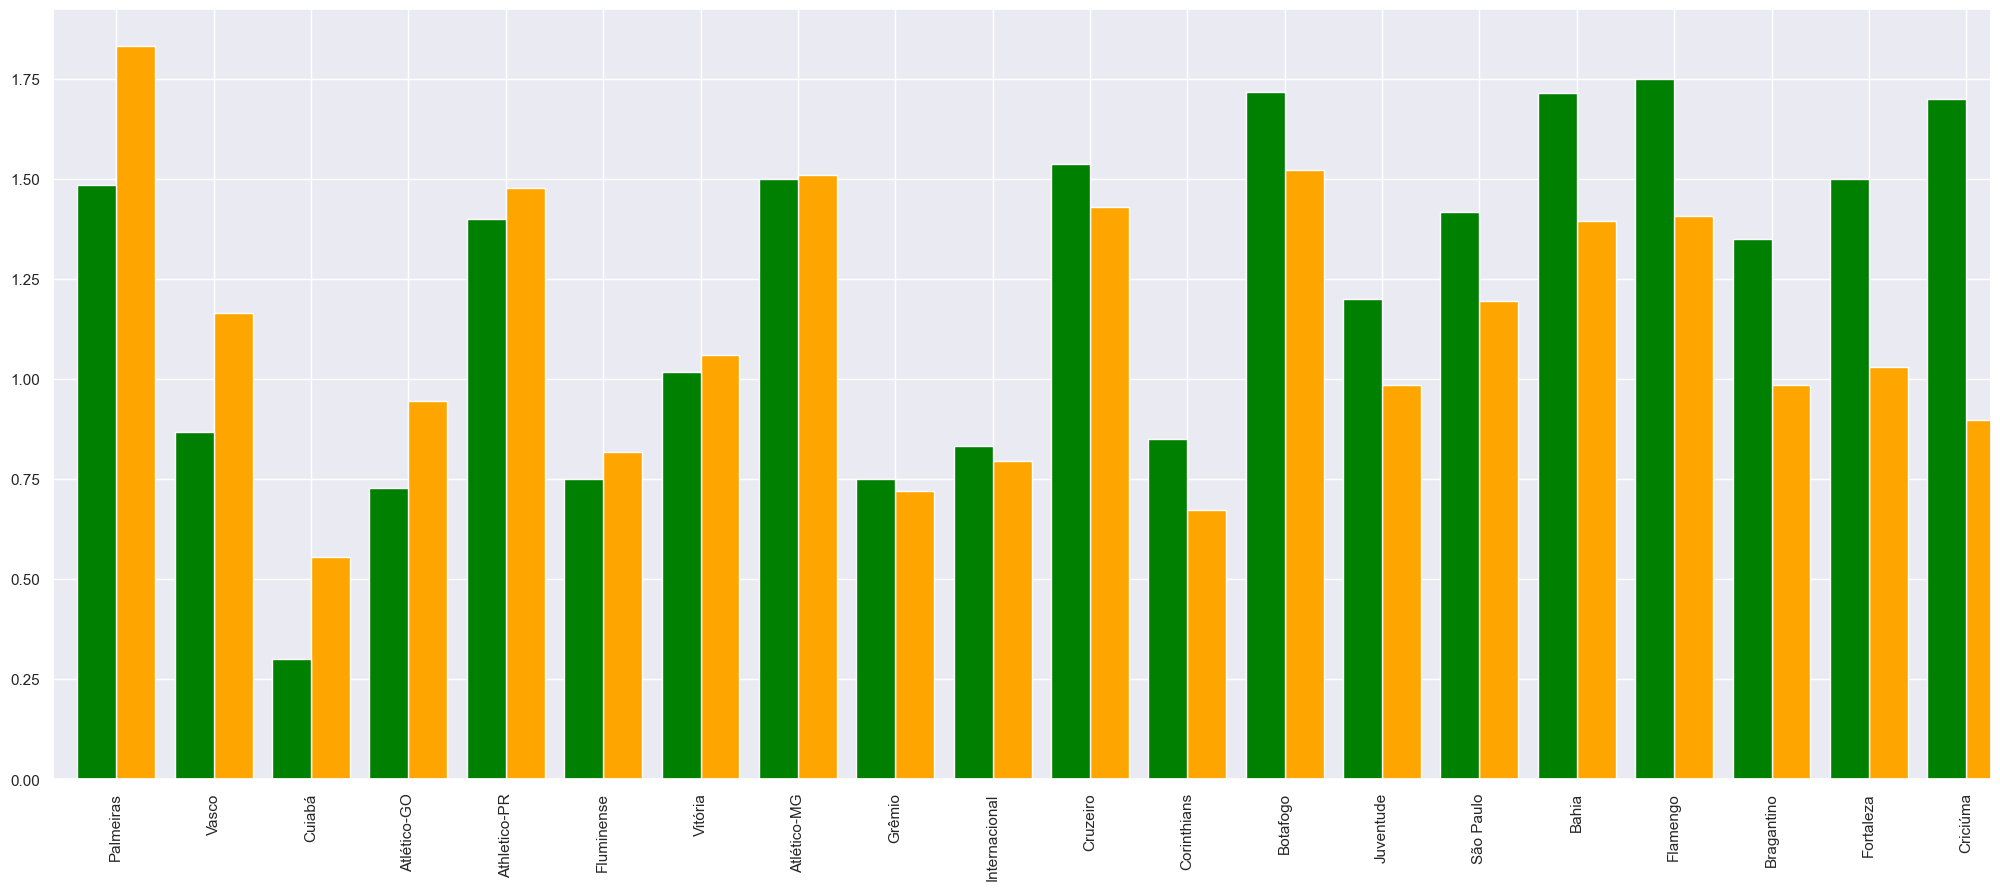

In [612]:
df_composite = plot_xg_vs_goals(df_xG_vs_Goals, rodada)

In [615]:
def plot_xG_vs_xGA(df):
    
    fig, ax = plt.subplots(figsize=(25, 10))
    sns.barplot(x="xG_diff_geral", y="clube", data=df)
    ax.figure.savefig(f'img/xg_scored_minus_conceded_r{rodada}.png')
    
    # Display the plot in the Jupyter Notebook
    plt.show()



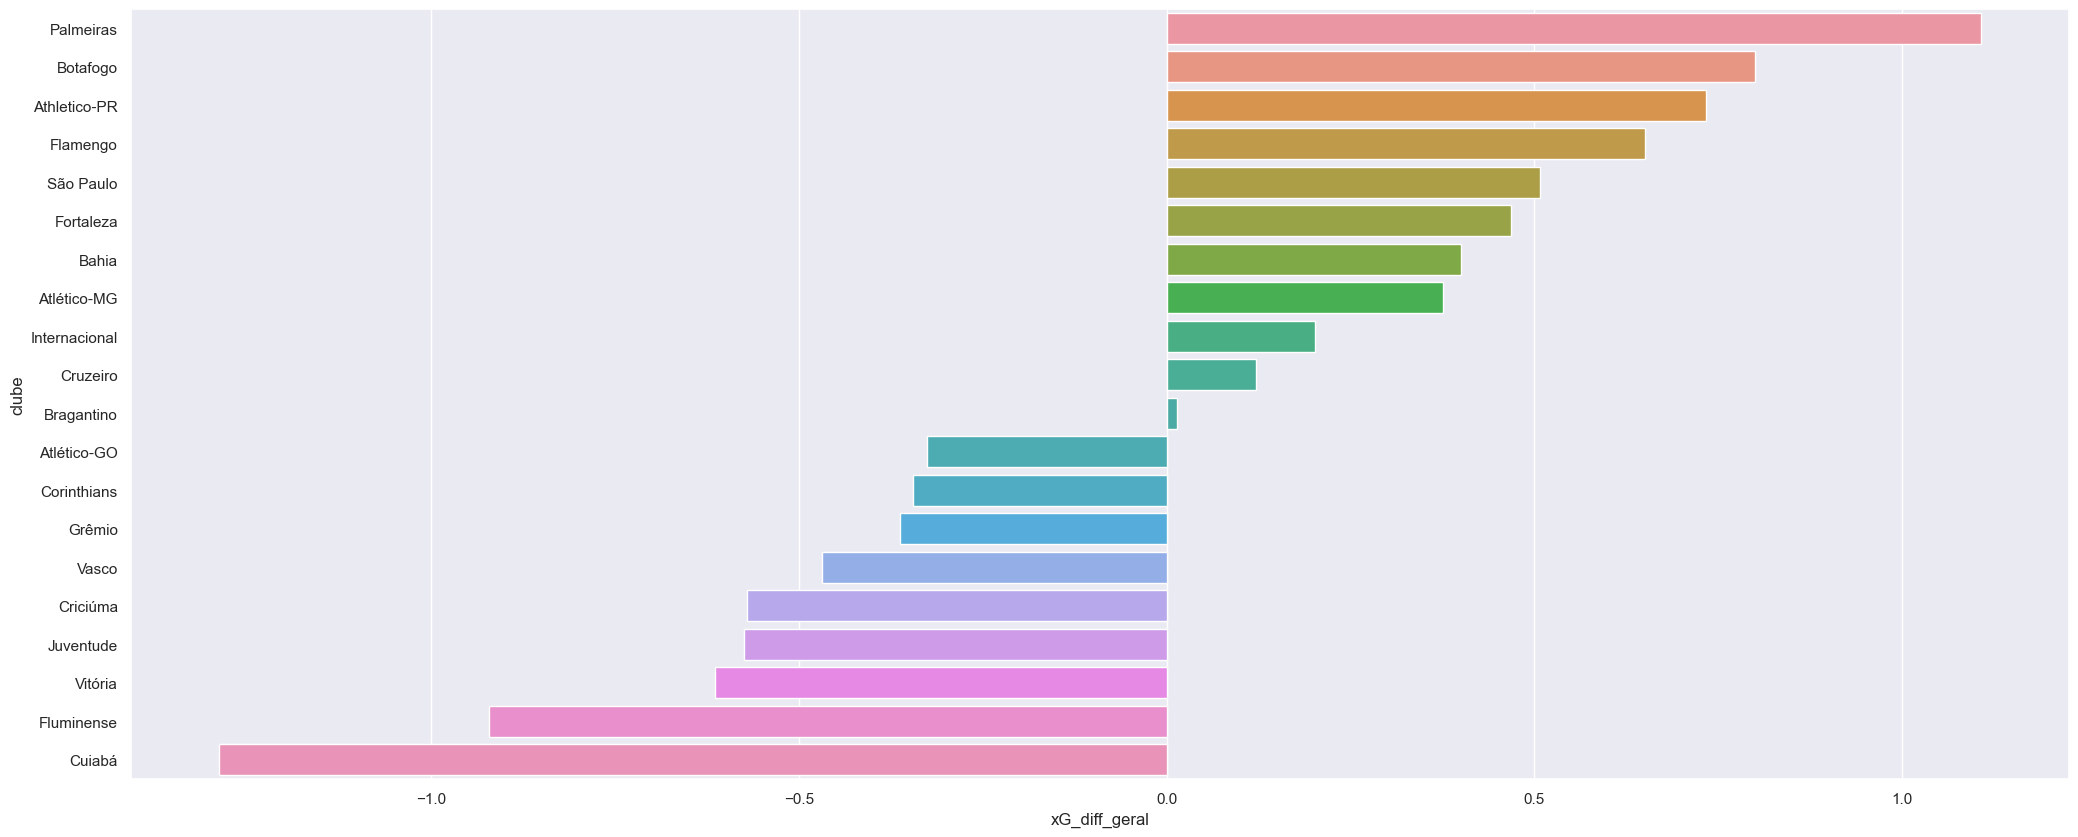

In [616]:
plot_xG_vs_xGA(df_xg_diff)

In [617]:
df_composite.head()

,clube,xG_casa,xGA_casa,xG_fora,xGA_fora,xG_geral,xGA_geral,xG_diff_casa,xG_diff_fora,xG_diff_geral,Goal_casa,GoalA_casa,Goal_fora,GoalA_fora,Goal_geral,GoalA_geral,Goal_diff_casa,Goal_diff_fora,Goal_diff_geral,xG_G_comp
0,Palmeiras,1.927362,0.891913,1.734467,0.556488,1.830915,0.724200,1.035449,1.177979,1.106714,1.166667,0.666667,1.800000,0.200000,1.483333,0.433333,0.500000,1.600000,1.050000,0.347581
1,Vasco,1.823193,1.741280,0.503435,1.523294,1.163314,1.632287,0.081913,-1.019859,-0.468973,1.333333,2.166667,0.400000,1.800000,0.866667,1.983333,-0.833333,-1.400000,-1.116667,0.296647
2,Cuiabá,0.101394,1.772143,1.008085,1.914512,0.554740,1.843327,-1.670749,-0.906426,-1.288587,0.000000,1.500000,0.600000,1.800000,0.300000,1.650000,-1.500000,-1.200000,-1.350000,0.254740
3,Atlético-GO,0.760937,1.675189,1.126424,0.864698,0.943681,1.269944,-0.914252,0.261726,-0.326263,0.600000,2.000000,0.857143,0.714286,0.728571,1.357143,-1.400000,0.142857,-0.628571,0.215109
4,Athletico-PR,1.880974,0.570696,1.070637,0.912968,1.475805,0.741832,1.310278,0.157669,0.733973,2.000000,0.500000,0.800000,0.800000,1.400000,0.650000,1.500000,0.000000,0.750000,0.075805


In [618]:
def xG_quadrantes(df_composite, rodada):
    df = df_composite.copy()
    # Calculate means for axis guidelines
    xG_geral_mean = np.mean(df['xG_geral'])
    xGA_geral_mean = np.mean(df['xGA_geral'])

    # Setting the theme for better aesthetics
    sns.set_theme()

    # Create a figure and an axes object
    fig, ax = plt.subplots(figsize=(20,10))

    # Create a scatter plot using keyword arguments
    p1 = sns.scatterplot(x='xGA_geral',  # Horizontal axis
                         y='xG_geral',   # Vertical axis
                         data=df,        # Data source
                         s=100,          # Size of the markers
                         legend=False,   # No legend
                         ax=ax)          # Plot on the ax created earlier

    # Draw horizontal and vertical lines at the mean values
    ax.axhline(y=xG_geral_mean, color='b', linewidth=1, linestyle='--')
    ax.axvline(x=xGA_geral_mean, color='r', linewidth=1, linestyle='--')

    # Add text labels for each point
    for line in range(0, df.shape[0]):
        ax.text(df.xGA_geral[line] + 0.01, df.xG_geral[line], 
                df.clube[line], horizontalalignment='left', 
                size='medium', color='black', weight='semibold')

    # Set titles and labels
    plt.title('xG Feitos Vs xG Cedidos')
    plt.xlabel('xGA - Expectativa de Gols Cedidos')
    plt.ylabel('xG - Expectativa de Gols Feitos')

    # Save the figure before showing it
    fig.savefig(f'img/xG_quadrantes{rodada}.png')

    # Show the plot
    plt.show()

    return df_composite


    


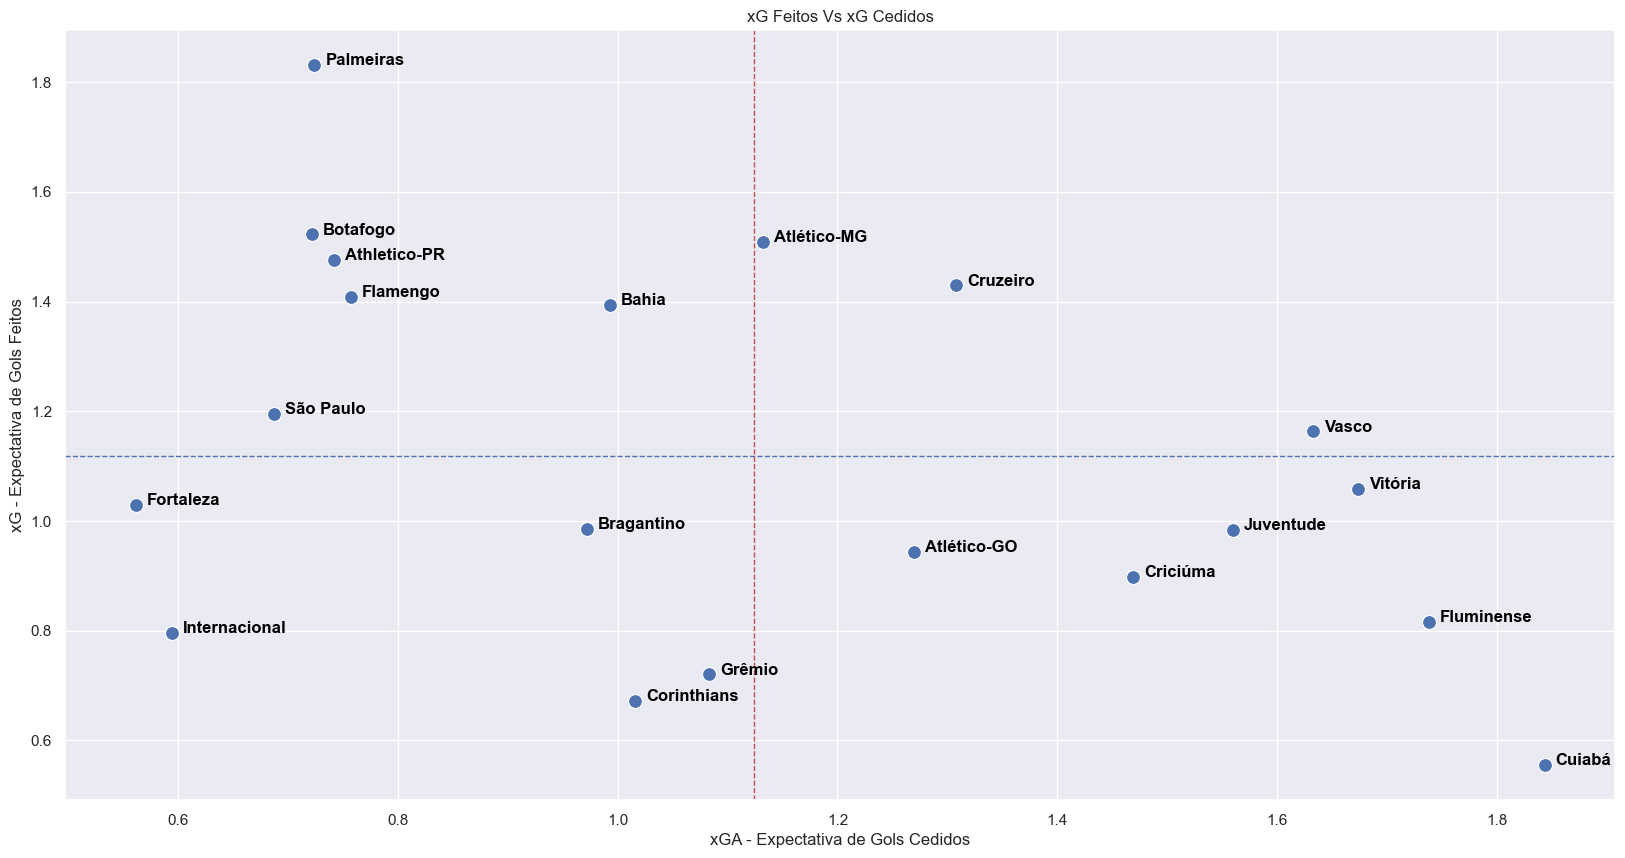

,clube,xG_casa,xGA_casa,xG_fora,xGA_fora,xG_geral,xGA_geral,xG_diff_casa,xG_diff_fora,xG_diff_geral,Goal_casa,GoalA_casa,Goal_fora,GoalA_fora,Goal_geral,GoalA_geral,Goal_diff_casa,Goal_diff_fora,Goal_diff_geral,xG_G_comp
0,Palmeiras,1.927362,0.891913,1.734467,0.556488,1.830915,0.724200,1.035449,1.177979,1.106714,1.166667,0.666667,1.800000,0.200000,1.483333,0.433333,0.500000,1.600000,1.050000,0.347581
1,Vasco,1.823193,1.741280,0.503435,1.523294,1.163314,1.632287,0.081913,-1.019859,-0.468973,1.333333,2.166667,0.400000,1.800000,0.866667,1.983333,-0.833333,-1.400000,-1.116667,0.296647
2,Cuiabá,0.101394,1.772143,1.008085,1.914512,0.554740,1.843327,-1.670749,-0.906426,-1.288587,0.000000,1.500000,0.600000,1.800000,0.300000,1.650000,-1.500000,-1.200000,-1.350000,0.254740
3,Atlético-GO,0.760937,1.675189,1.126424,0.864698,0.943681,1.269944,-0.914252,0.261726,-0.326263,0.600000,2.000000,0.857143,0.714286,0.728571,1.357143,-1.400000,0.142857,-0.628571,0.215109
4,Athletico-PR,1.880974,0.570696,1.070637,0.912968,1.475805,0.741832,1.310278,0.157669,0.733973,2.000000,0.500000,0.800000,0.800000,1.400000,0.650000,1.500000,0.000000,0.750000,0.075805
5,Fluminense,1.192975,1.629175,0.440198,1.846385,0.816586,1.737780,-0.436199,-1.406187,-0.921193,1.333333,1.500000,0.166667,1.833333,0.750000,1.666667,-0.166667,-1.666667,-0.916667,0.066586
6,Vitória,1.193051,1.353711,0.924429,1.993725,1.058740,1.673718,-0.160661,-1.069296,-0.614979,1.285714,1.714286,0.750000,2.000000,1.017857,1.857143,-0.428571,-1.250000,-0.839286,0.040883
7,Atlético-MG,1.356816,1.314148,1.659788,0.949960,1.508302,1.132054,0.042668,0.709828,0.376248,1.200000,1.400000,1.800000,1.400000,1.500000,1.400000,-0.200000,0.400000,0.100000,0.008302
8,Grêmio,0.862663,0.555656,0.577946,1.610829,0.720304,1.083242,0.307007,-1.032883,-0.362938,0.833333,0.666667,0.666667,1.666667,0.750000,1.166667,0.166667,-1.000000,-0.416667,-0.029696
9,Internacional,0.802222,0.382564,0.788359,0.806070,0.795290,0.594317,0.419658,-0.017712,0.200973,1.000000,0.500000,0.666667,0.666667,0.833333,0.583333,0.500000,0.000000,0.250000,-0.038043


In [619]:
xG_quadrantes(df_composite,rodada)

In [620]:
jogos, confrontos, jogos_que_faltam = get_jogos_sde(2024,rodada,times_dict)
jogos

{'Cuiabá': 'Botafogo',
 'Vasco': 'Fortaleza',
 'Criciúma': 'Cruzeiro',
 'Atlético-MG': 'Flamengo',
 'Bragantino': 'Atlético-GO',
 'Athletico-PR': 'São Paulo',
 'Grêmio': 'Palmeiras',
 'Bahia': 'Juventude',
 'Fluminense': 'Internacional',
 'Corinthians': 'Vitória'}

In [621]:
df_xg_diff

,clube,xG_casa,xGA_casa,xG_fora,xGA_fora,xG_geral,xGA_geral,xG_diff_casa,xG_diff_fora,xG_diff_geral
0,Palmeiras,1.927362,0.891913,1.734467,0.556488,1.830915,0.724200,1.035449,1.177979,1.106714
1,Botafogo,1.861019,0.628290,1.183624,0.815858,1.522322,0.722074,1.232729,0.367766,0.800248
2,Athletico-PR,1.880974,0.570696,1.070637,0.912968,1.475805,0.741832,1.310278,0.157669,0.733973
3,Flamengo,1.114815,0.808174,1.700648,0.706587,1.407732,0.757380,0.306642,0.994061,0.650351
4,São Paulo,1.098375,0.447898,1.291237,0.926388,1.194806,0.687143,0.650477,0.364849,0.507663
5,Fortaleza,0.752709,0.567393,1.306137,0.555840,1.029423,0.561616,0.185317,0.750297,0.467807
6,Bahia,1.989869,0.752943,0.797458,1.233158,1.393664,0.993050,1.236926,-0.435700,0.400613
7,Atlético-MG,1.356816,1.314148,1.659788,0.949960,1.508302,1.132054,0.042668,0.709828,0.376248
8,Internacional,0.802222,0.382564,0.788359,0.806070,0.795290,0.594317,0.419658,-0.017712,0.200973
9,Cruzeiro,2.099058,1.107641,0.759530,1.508049,1.429294,1.307845,0.991417,-0.748520,0.121449


In [622]:
def xG_probs(df_xg_diff, edicao, rodada, times_dict, times_dict_r):
    jogos, confrontos, jogos_que_faltam = get_jogos_sde(edicao, rodada, times_dict)
    df_xG_probs = pd.DataFrame()

    for m, v in jogos.items():
        m = times_dict_r.get(m, m)  # Ensure a default fallback to original if not found
        v = times_dict_r.get(v, v)  # Ensure a default fallback to original if not found

        # Extract data safely
        if m in df_xg_diff['clube'].values and v in df_xg_diff['clube'].values:
            xG_casa = df_xg_diff.loc[df_xg_diff['clube'] == m, 'xG_casa'].iloc[0]
            xGA_casa = df_xg_diff.loc[df_xg_diff['clube'] == m, 'xGA_casa'].iloc[0]
            xG_fora = df_xg_diff.loc[df_xg_diff['clube'] == v, 'xG_fora'].iloc[0]
            xGA_fora = df_xg_diff.loc[df_xg_diff['clube'] == v, 'xGA_fora'].iloc[0]

            # Calculate average expected goals
            xG_mandante_avg = (xG_casa + xGA_fora) / 2
            xG_visitante_avg = (xG_fora + xGA_casa) / 2

            # Create a new DataFrame to append
            new_row = pd.DataFrame({
                'next_rodada_id': [rodada + 1],
                'mandante': [m],
                'visitante': [v],
                'xG_mandante': [xG_mandante_avg],
                'xG_visitante': [xG_visitante_avg]
            })
            
            # Append to DataFrame using concat
            df_xG_probs = pd.concat([df_xG_probs, new_row], ignore_index=True)
        else:
            print(f"Missing data for clubs: {m} or {v}")

    return df_xG_probs

df_simul = xG_probs(df_xg_diff,2024,rodada,times_dict, times_dict_r)

In [623]:
df_simul

,next_rodada_id,mandante,visitante,xG_mandante,xG_visitante
0,14,Cuiabá,Botafogo,0.458626,1.477884
1,14,Vasco,Fortaleza,1.189516,1.523709
2,14,Criciúma,Cruzeiro,1.068893,0.985790
3,14,Atlético-MG,Flamengo,1.031702,1.507398
4,14,Bragantino,Atlético-GO,1.042891,0.995991
5,14,Athletico-PR,São Paulo,1.403681,0.930967
6,14,Grêmio,Palmeiras,0.709576,1.145061
7,14,Bahia,Juventude,2.240304,0.843266
8,14,Fluminense,Internacional,0.999523,1.208767
9,14,Corinthians,Vitória,1.383718,0.868688


In [624]:
# jogos, confrontos, jogos_que_faltam = get_jogos_sde(2024,rodada,times_dict)
# print('Jogos da próxima rodada',jogos)
# # container for all simulations
# df_xG_probs = pd.DataFrame()
# for m, v in jogos.items():
#     m = times_dict.get(m)
#     v = times_dict.get(v)
#     print(m, v)

In [625]:
def simulate_round(df_xg_diff, edicao, rodada):
    _, clubes_e_ids, _ = get_equipes_sde(edicao)
    times_dict = clubes_e_ids
    times_dict_r = {v:k for k, v in times_dict.items()}

    jogos, confrontos, jogos_que_faltam = get_jogos_sde(edicao,rodada,times_dict)
    print('Jogos da próxima rodada',jogos)
    # container for all simulations
    df_xG_probs = pd.DataFrame()
    for m, v in jogos.items():
        m = times_dict_r.get(m, m)  # Ensure a default fallback to original if not found
        v = times_dict_r.get(v, v)  # Ensure a default fallback to original if not found
        print (m,v)
        if m in df_xg_diff['clube'].values and v in df_xg_diff['clube'].values:
            xG_casa = df_xg_diff.loc[df_xg_diff['clube'] == m, 'xG_casa'].iloc[0]
            xGA_casa = df_xg_diff.loc[df_xg_diff['clube'] == m, 'xGA_casa'].iloc[0]
            xG_fora = df_xg_diff.loc[df_xg_diff['clube'] == v, 'xG_fora'].iloc[0]
            xGA_fora = df_xg_diff.loc[df_xg_diff['clube'] == v, 'xGA_fora'].iloc[0]

            # Calculate average expected goals
            xG_mandante_avg = (xG_casa + xGA_fora) / 2
            xG_visitante_avg = (xG_fora + xGA_casa) / 2

            # Create a new DataFrame to append
            new_row = pd.DataFrame({
                'next_rodada_id': [rodada + 1],
                'mandante': [m],
                'visitante': [v],
                'xG_mandante': [xG_mandante_avg],
                'xG_visitante': [xG_visitante_avg]
            })
            
            # Append to DataFrame using concat
            df_xG_probs = pd.concat([df_xG_probs, new_row], ignore_index=True)
        else:
            print(f"Missing data for clubs: {m} or {v}")
    # Poisson with MonteCarlo Simulation
    all_homes = []
    all_aways=[]
    all_draws=[]
    all_homes_sg=[]
    all_aways_sg=[]
    all_draws_sg=[]
    all_home_xP = []
    all_away_xP = []
    num_simulations = 20000

    for i,row in df_xG_probs.iterrows():
        print("* Game #", i+1, "*")
        print("* Home team:", df_xG_probs.iloc[i]['mandante'])
        print("* Away team:", df_xG_probs.iloc[i]['visitante'])
        print("* Home team xG:", df_xG_probs.iloc[i]['xG_mandante'])
        print("* Away team xG:", df_xG_probs.iloc[i]['xG_visitante'])
        input_home_team = df_xG_probs.iloc[i]['mandante']
        input_home_team_xg = df_xG_probs.iloc[i]['xG_mandante']
        input_away_team = df_xG_probs.iloc[i]['visitante']
        input_away_team_xg = df_xG_probs.iloc[i]['xG_visitante']
        #print the simulation table and run simulations
        # print ("********************")
        # print ("*                  *")
        # print ("* SIMULATION TABLE *")
        # print ("*                  *")
        # print ("********************")
        count_home_wins = 0
        count_home_loss = 0
        count_away_wins = 0
        count_away_loss = 0
        count_draws = 0
        count_home_sg = 0
        count_away_sg = 0
        count_draw_sg = 0

        score_mat = []
        tot_sim_time = 0
        sim_table = PrettyTable(["SIMULATION #", "SIMULATION TIME (s)", input_home_team, input_away_team, "HOME WIN", "AWAY WIN", "DRAW", "SCORE MARGIN", "SG"])
        for i in range(num_simulations):
            #get simulation start time
            start_time = time.time()
            #run the sim - generate a random Poisson distribution
            target_home_goals_scored = np.random.poisson(input_home_team_xg)
            target_away_goals_scored = np.random.poisson(input_away_team_xg)
            home_win = 0
            away_win = 0
            draw = 0
            margin = 0
            sg = 0
            # if more goals for home team => home team wins
            if target_home_goals_scored > target_away_goals_scored:
                count_home_wins += 1
                count_away_loss += 1
                home_win = 1
                margin = target_home_goals_scored - target_away_goals_scored
                # check if sg
                if target_away_goals_scored == 0:
                    sg = 1
                    count_home_sg += 1
            # if more goals for away team => away team wins
            elif target_home_goals_scored < target_away_goals_scored:
                count_away_wins += 1
                count_home_loss += 1
                away_win = 1
                margin = target_away_goals_scored - target_home_goals_scored
                # check if sg
                if target_home_goals_scored == 0:
                    sg = 1
                    count_away_sg += 1
            elif target_home_goals_scored == target_away_goals_scored:
                draw = 1
                count_draws += 1
                margin = target_away_goals_scored - target_home_goals_scored
                # check if sg
                if target_home_goals_scored == 0 and target_away_goals_scored == 0:
                    sg = 1
                    count_draw_sg += 1
            # add score to score matrix
            score_mat.append((target_home_goals_scored, target_away_goals_scored))
            #get end time
            end_time = time.time()
            #add the time to the total simulation time
            tot_sim_time += round((end_time - start_time),5)
            #add the info to the simulation table
            sim_table.add_row([i+1, round((end_time - start_time),5), target_home_goals_scored, target_away_goals_scored, home_win, away_win, draw, margin, sg])
        #print(sim_table)

        # calculate probabilities to win/lose/draw
        home_win_probability = round((count_home_wins/num_simulations * 100),2)
        all_homes.append(home_win_probability)

        away_win_probability = round((count_away_wins/num_simulations * 100),2)
        all_aways.append(away_win_probability)

        draw_probability = round((count_draws/num_simulations * 100),2)
        all_draws.append(draw_probability)

        home_sg_probability = round((count_home_sg/num_simulations * 100),2)
        all_homes_sg.append(home_sg_probability)

        away_sg_probability = round((count_away_sg/num_simulations * 100),2)
        all_aways_sg.append(away_sg_probability)

        draw_sg_probability = round((count_draw_sg/num_simulations * 100),2)
        all_draws_sg.append(draw_sg_probability)
        
#         home_xP = round((home_win_probability / 100) * 3.0 + (draw_probability / 100) * 1.0 + (away_win_probability / 100) * 0.0, 2)
#         all_home_xP.append(home_xP)
        
#         away_xP = round((away_win_probability / 100) * 3.0 + (draw_probability / 100) * 1.0 + (home_win_probability / 100) * 0.0, 2)
#         all_away_xP.append(away_xP)

        # print the simulation statistics
        # print ("*************")
        # print ("*           *")
        # print ("* SIM STATS *")
        # print ("*           *")
        # print ("*************")
        sim_table_stats = PrettyTable(["Total # of sims", "Total time (s) for sims", "HOME WINS", "AWAY WINS", "DRAWS", "HOME SG", "AWAY SG", "DRAW SG"])
        sim_table_stats.add_row([num_simulations, round(tot_sim_time,3), count_home_wins, count_away_wins, count_draws, count_home_sg, count_away_sg, count_draw_sg])
        sim_table_stats.add_row(["-", "-", str(home_win_probability)+"%", str(away_win_probability)+"%", str(draw_probability)+"%", str(home_sg_probability)+"%", str(away_sg_probability)+"%", str(draw_sg_probability)+"%"])
        print(sim_table_stats)


    df_xG_probs['percent_mandante'] = all_homes
    df_xG_probs['percent_visitante'] = all_aways
    df_xG_probs['percent_empate'] = all_draws

    df_xG_probs['percent_sg_mandante'] = all_homes_sg
    df_xG_probs['percent_sg_visitante'] = all_aways_sg
    df_xG_probs['percent_sg_empate'] = all_draws_sg
    
    # df_xG_probs['xP_mandante'] = all_home_xP
    # df_xG_probs['xP_visitante'] = all_away_xP

    return df_xG_probs

In [626]:
df_xG_probs = simulate_round(df_xg_diff, 2024, rodada)

Jogos da próxima rodada {'Cuiabá': 'Botafogo', 'Vasco': 'Fortaleza', 'Criciúma': 'Cruzeiro', 'Atlético-MG': 'Flamengo', 'Bragantino': 'Atlético-GO', 'Athletico-PR': 'São Paulo', 'Grêmio': 'Palmeiras', 'Bahia': 'Juventude', 'Fluminense': 'Internacional', 'Corinthians': 'Vitória'}
Cuiabá Botafogo
Vasco Fortaleza
Criciúma Cruzeiro
Atlético-MG Flamengo
Bragantino Atlético-GO
Athletico-PR São Paulo
Grêmio Palmeiras
Bahia Juventude
Fluminense Internacional
Corinthians Vitória
* Game # 1 *
* Home team: Cuiabá
* Away team: Botafogo
* Home team xG: 0.4586260750424117
* Away team xG: 1.4778835847042502
+-----------------+-------------------------+-----------+-----------+-------+---------+---------+---------+
| Total # of sims | Total time (s) for sims | HOME WINS | AWAY WINS | DRAWS | HOME SG | AWAY SG | DRAW SG |
+-----------------+-------------------------+-----------+-----------+-------+---------+---------+---------+
|      20000      |          0.023          |    2212   |   12689   |  5099 

In [627]:
df_xG_probs['sg_mandante_total'] = df_xG_probs['percent_sg_mandante'] + df_xG_probs['percent_sg_empate']
df_xG_probs['sg_visitante_total'] = df_xG_probs['percent_sg_visitante'] + df_xG_probs['percent_sg_empate']
#df_xG_probs['sg_total'] = df_xG_probs['sg_mandante_total'] + df_xG_probs['sg_visitante_total']

In [628]:
df_xG_probs = df_xG_probs.assign(val=df_xG_probs[['sg_mandante_total', 'sg_visitante_total']].max(axis=1)) \
                         .sort_values(by='val', ascending=False) \
                         .drop(columns='val') \
                         .reset_index(drop=True).copy()


In [629]:
df_xG_probs

,next_rodada_id,mandante,visitante,xG_mandante,xG_visitante,percent_mandante,percent_visitante,percent_empate,percent_sg_mandante,percent_sg_visitante,percent_sg_empate,sg_mandante_total,sg_visitante_total
0,14,Cuiabá,Botafogo,0.458626,1.477884,11.06,63.44,25.50,8.29,49.63,14.37,22.66,64.00
1,14,Grêmio,Palmeiras,0.709576,1.145061,22.46,46.39,31.14,15.90,33.80,15.71,31.61,49.51
2,14,Bahia,Juventude,2.240304,0.843266,69.08,12.74,18.18,38.00,6.07,4.46,42.46,10.53
3,14,Corinthians,Vitória,1.383718,0.868688,48.67,23.57,27.77,31.20,14.59,10.46,41.66,25.05
4,14,Athletico-PR,São Paulo,1.403681,0.930967,47.89,24.85,27.26,29.60,14.96,10.04,39.64,25.00
5,14,Criciúma,Cruzeiro,1.068893,0.985790,37.16,32.38,30.46,24.62,21.34,12.88,37.50,34.22
6,14,Bragantino,Atlético-GO,1.042891,0.995991,36.05,33.55,30.40,23.88,22.18,13.28,37.16,35.46
7,14,Fluminense,Internacional,0.999523,1.208767,30.39,40.86,28.74,18.84,25.86,10.66,29.50,36.52
8,14,Atlético-MG,Flamengo,1.031702,1.507398,25.73,48.60,25.67,13.83,28.14,8.01,21.84,36.15
9,14,Vasco,Fortaleza,1.189516,1.523709,30.14,44.89,24.98,15.58,23.78,6.37,21.95,30.15


In [630]:
df_xG_probs.to_csv(f'sg_xg_R{rodada}_2024.csv')

In [631]:
# modelo_xG = pd.read_csv('clubes_xG_probs_R10.csv')
# modelo_gols = pd.read_csv('df_probabilidades_R10.csv')
# odds = pd.read_csv('df_odds_R10.csv')

# df_jogos = pd.DataFrame({'mandante':[m for m,v in jogos.items()],'visitante':[v for m,v in jogos.items()]})
# df_jogos['mandante'] = df_jogos['mandante'].map(times_dict_r)
# df_jogos['visitante'] = df_jogos['visitante'].map(times_dict_r)



# print(modelo_gols)
# print(modelo_xG)
# odds['odds_mandante_percent'] = (1/odds['odds_mandante'])*100
# odds['odds_visitante_percent'] = (1/odds['odds_visitante'])*100
# odds['odds_empate_percent'] = (1/odds['odds_empate'])*100

#odds_reduced = df_jogos.merge(odds, how='left', left_on=['mandante','visitante'], right_on=['mandante','visitante'])
# ##

# models = modelo_gols.merge(modelo_xG, how='left', left_on=['mandante','visitante'], right_on=['mandante','visitante'])


# all_models = models.merge(odds_reduced, how='left', left_on=['mandante','visitante'], right_on=['mandante','visitante'])

# all_models['prob_mandante_media'] = (all_models['percent_mandante']+all_models['prob_vitoria_mandante']+all_models['odds_mandante_percent'])/3
# all_models['prob_visitante_media'] = (all_models['percent_visitante']+all_models['prob_vitoria_visitante']+all_models['odds_visitante_percent'])/3
# all_models['prob_empate_media'] = (all_models['percent_empate']+all_models['prob_empate']+all_models['odds_empate_percent'])/3
# all_models['prob_sg_mandante_media'] = (all_models['percent_sg_mandante']+all_models['prob_sg_mandante'])/2
# all_models['prob_sg_visitante_media'] = (all_models['percent_sg_visitante']+all_models['prob_sg_visitante'])/2

# all_models = all_models[['rodada_id','mandante','visitante','prob_mandante_media','prob_empate_media','prob_visitante_media','prob_sg_mandante_media','prob_sg_visitante_media']]
# all_models


In [632]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable

def xG_philosophy_clubes(df_brasileiro, clube=None, confrontos=None, rodada=None):
    # Simulated fetch function, replace these with actual data fetching methods
    _, clubes_e_ids, _ = get_equipes_sde(2024)
    times_dict = clubes_e_ids  # Assuming this dictionary maps club names to IDs
    times_dict_r = {v: k for k, v in times_dict.items()}  # Reverse map from IDs to names

    print("Club ID to Name Mapping:", times_dict_r)  # Debugging line

    df_clubes_xg = df_brasileiro.groupby(['clube_id', 'rodada_id'])['xG'].agg([('xG_sum', 'sum')]).reset_index()
    df_clubes_g = df_brasileiro.groupby(['clube_id', 'rodada_id'])['Goal'].agg([('Goal', 'sum')]).reset_index()
    df_philo = df_clubes_xg.merge(df_clubes_g, how='left', on=['clube_id', 'rodada_id'])
    df_philo['clube'] = df_philo['clube_id'].map(times_dict_r)

    if clube:
        clube_id = times_dict.get(clube)  # Get the clube_id for the given clube name
        df_philo_clube = df_philo[df_philo['clube_id'] == clube_id]

        if not df_philo_clube.empty:
            fig = plt.figure(figsize=(20, 10))
            ax = fig.add_subplot(111)
            ax.plot(df_philo_clube['rodada_id'], df_philo_clube['Goal'], c='b', marker="v", ls='-', label='Goals')
            ax.plot(df_philo_clube['rodada_id'], df_philo_clube['xG_sum'], c='m', marker="o", ls='--', label='xG', fillstyle='none')
            plt.legend(loc=2)
            plt.show()
        return df_philo_clube

    if confrontos:
        jogos, _, _ = get_jogos_sde(2024, rodada-1, times_dict)
        jogos_id_mapped = {times_dict.get(k, None): times_dict.get(v, None) for k, v in jogos.items()}
        print("Mapped Jogos with IDs:", jogos_id_mapped)  # Debug
        print()

        for k, v in jogos_id_mapped.items():
            if k is None or v is None:
                continue  # Skip if no valid ID is found

            #print(f'Checking game between {times_dict_r.get(k, "Unknown")} and {times_dict_r.get(v, "Unknown")} at rodada {rodada}')  # Debug names
            df_philo_confronto = df_philo[(df_philo['clube_id'] == k) | (df_philo['clube_id'] == v)]
            df_philo_confronto = df_philo_confronto[df_philo_confronto['rodada_id'] == rodada]

            if not df_philo_confronto.empty:
                mandante = df_philo_confronto[df_philo_confronto['clube_id'] == k]['clube'].iloc[0]
                visitante = df_philo_confronto[df_philo_confronto['clube_id'] == v]['clube'].iloc[0]
                gols_mandante = df_philo_confronto[df_philo_confronto['clube_id'] == k]['Goal'].iloc[0]
                gols_visitante = df_philo_confronto[df_philo_confronto['clube_id'] == v]['Goal'].iloc[0]
                xg_mandante = df_philo_confronto[df_philo_confronto['clube_id'] == k]['xG_sum'].iloc[0]
                xg_visitante = df_philo_confronto[df_philo_confronto['clube_id'] == v]['xG_sum'].iloc[0]

                print(f'{mandante} ({xg_mandante.round(2)}) {gols_mandante} X {gols_visitante} ({xg_visitante.round(2)}) {visitante}')
                print()

    return df_philo



In [633]:
xG_philosophy_clubes(df_brasileiro,confrontos=True,rodada=rodada)


Club ID to Name Mapping: {293: 'Athletico-PR', 373: 'Atlético-GO', 282: 'Atlético-MG', 265: 'Bahia', 263: 'Botafogo', 280: 'Bragantino', 264: 'Corinthians', 288: 'Criciúma', 283: 'Cruzeiro', 1371: 'Cuiabá', 262: 'Flamengo', 266: 'Fluminense', 356: 'Fortaleza', 284: 'Grêmio', 285: 'Internacional', 286: 'Juventude', 275: 'Palmeiras', 276: 'São Paulo', 267: 'Vasco', 287: 'Vitória'}
Mapped Jogos with IDs: {267: 263, 1371: 280, 282: 373, 284: 266, 276: 265, 356: 286, 287: 293, 262: 283, 288: 285, 275: 264}

Atlético-MG (1.13) 1 X 1 (1.22) Atlético-GO

Grêmio (0.48) 1 X 0 (0.12) Fluminense

São Paulo (2.16) 3 X 1 (0.63) Bahia

Vitória (0.45) 0 X 1 (0.21) Athletico-PR

Flamengo (1.28) 2 X 1 (0.67) Cruzeiro

Criciúma (0.35) 1 X 1 (1.1) Internacional



,clube_id,rodada_id,xG_sum,Goal,clube
0,262,1,1.410458,2,Flamengo
1,262,2,1.632799,2,Flamengo
2,262,3,0.116139,0,Flamengo
3,262,4,0.145544,0,Flamengo
4,262,5,0.412716,1,Flamengo
...,...,...,...,...,...
201,1371,7,0.165061,0,Cuiabá
202,1371,8,1.541774,1,Cuiabá
203,1371,10,0.197147,1,Cuiabá
204,1371,11,0.107336,0,Cuiabá


In [634]:
xG_philosophy_clubes(df_brasileiro,clube=262,rodada=rodada)

Club ID to Name Mapping: {293: 'Athletico-PR', 373: 'Atlético-GO', 282: 'Atlético-MG', 265: 'Bahia', 263: 'Botafogo', 280: 'Bragantino', 264: 'Corinthians', 288: 'Criciúma', 283: 'Cruzeiro', 1371: 'Cuiabá', 262: 'Flamengo', 266: 'Fluminense', 356: 'Fortaleza', 284: 'Grêmio', 285: 'Internacional', 286: 'Juventude', 275: 'Palmeiras', 276: 'São Paulo', 267: 'Vasco', 287: 'Vitória'}


,clube_id,rodada_id,xG_sum,Goal,clube


In [635]:
# df_brasileiro.info()
# df_brasileiro.to_csv('df_brasileiro.csv')

# xG Atletas

#### Agora vamos fazer o cálculo de xG etc sob a perspectiva dos atletas

- Estudo 01. xG total
- Estudo 02. xG por jogo
- Estudo 03. xG vs gols
- Estudo 04. xG como medida de eficiência
- Estudo 05. xG como medida de potencial

## xG Total

In [637]:
df_atletas = df_brasileiro.groupby(['atleta_id', 'apelido','clube_id'])['xG'].sum().reset_index()
df_atletas = df_atletas.sort_values(by='xG',ascending=False).reset_index(drop=True)
df_atletas = df_atletas[df_atletas['clube_id'].isin(clubes_ids)].reset_index(drop=True)
df_atletas['clube'] = df_atletas['clube_id'].map(times_dict_r)
df_atletas['clube'] = df_atletas['clube'].map(team_icons)

df_atletas = df_atletas[['apelido','clube_id','clube','xG']]
df_atletas.head(30)

,apelido,clube_id,clube,xG
0,Vegetti,267,![Vasco](https://s.glbimg.com/es/sde/f/organiz...,5.861885
1,Pedro,262,![Flamengo](https://s.glbimg.com/es/sde/f/orga...,4.594973
2,Mastriani,293,![Athletico-PR](https://s.glbimg.com/es/sde/f/...,4.339571
3,Luciano,276,![São Paulo](https://s.glbimg.com/es/sde/f/org...,3.999618
4,Everaldo,265,![Bahia](https://s.glbimg.com/es/sde/f/organiz...,3.770518
5,Paulinho,282,![Atlético-MG](https://s.glbimg.com/es/sde/f/o...,3.697590
6,Pablo,293,![Athletico-PR](https://s.glbimg.com/es/sde/f/...,3.593583
7,Cano,266,![Fluminense](https://s.glbimg.com/es/sde/f/or...,3.540117
8,Estêvão,275,![Palmeiras](https://s.glbimg.com/es/sde/f/org...,3.469891
9,Calleri,276,![São Paulo](https://s.glbimg.com/es/sde/f/org...,3.432951


## Adiconar métricas 

- xG_per_match
- xG_per_shot
- shots_per_goal

In [638]:
df_atletas2 = df_brasileiro.groupby(['atleta_id', 'apelido', 'clube_id']).agg(xG_total=('xG', 'sum'),
                                                                             shots_total=('Lance', 'count'),
                                                                             jogos_num=('rodada_id', 'nunique'),
                                                                             goals_total=('Goal', 'sum')).reset_index()
df_atletas2['xG_per_match']=df_atletas2['xG_total']/df_atletas2['jogos_num']
df_atletas2['G_per_match']=df_atletas2['goals_total']/df_atletas2['jogos_num']
df_atletas2['xG_per_shot'] = df_atletas2['xG_total']/df_atletas2['shots_total']
df_atletas2['shots_per_goal'] = df_atletas2['shots_total']/df_atletas2['goals_total']
df_atletas2['clube'] = df_atletas2['clube_id'].map(times_dict_r)
df_atletas2['clube'] = df_atletas2['clube'].map(team_icons)

xg_total = df_atletas2.sort_values(by='xG_total',ascending=False).reset_index(drop=True)

#df_atletas2 = df_atletas2[df_atletas2['clube_id'].isin(clubes_ids)].sort_values(by='xG_total',ascending=False).reset_index(drop=True)

xg_total.head(50)

,atleta_id,apelido,clube_id,xG_total,shots_total,jogos_num,goals_total,xG_per_match,G_per_match,xG_per_shot,shots_per_goal,clube
0,99198,Vegetti,267,5.861885,35,9,4,0.651321,0.444444,0.167482,8.750000,![Vasco](https://s.glbimg.com/es/sde/f/organiz...
1,94583,Pedro,262,4.594973,25,11,5,0.417725,0.454545,0.183799,5.000000,![Flamengo](https://s.glbimg.com/es/sde/f/orga...
2,102561,Mastriani,293,4.339571,16,6,4,0.723262,0.666667,0.271223,4.000000,![Athletico-PR](https://s.glbimg.com/es/sde/f/...
3,80287,Luciano,276,3.999618,23,9,4,0.444402,0.444444,0.173896,5.750000,![São Paulo](https://s.glbimg.com/es/sde/f/org...
4,78117,Everaldo,265,3.770518,21,10,5,0.377052,0.500000,0.179548,4.200000,![Bahia](https://s.glbimg.com/es/sde/f/organiz...
5,99818,Paulinho,282,3.697590,19,7,4,0.528227,0.571429,0.194610,4.750000,![Atlético-MG](https://s.glbimg.com/es/sde/f/o...
6,69138,Pablo,293,3.593583,13,5,3,0.718717,0.600000,0.276429,4.333333,![Athletico-PR](https://s.glbimg.com/es/sde/f/...
7,79631,Cano,266,3.540117,24,8,2,0.442515,0.250000,0.147505,12.000000,![Fluminense](https://s.glbimg.com/es/sde/f/or...
8,128915,Estêvão,275,3.469891,29,9,3,0.385543,0.333333,0.119651,9.666667,![Palmeiras](https://s.glbimg.com/es/sde/f/org...
9,89840,Calleri,276,3.432951,21,11,3,0.312086,0.272727,0.163474,7.000000,![São Paulo](https://s.glbimg.com/es/sde/f/org...


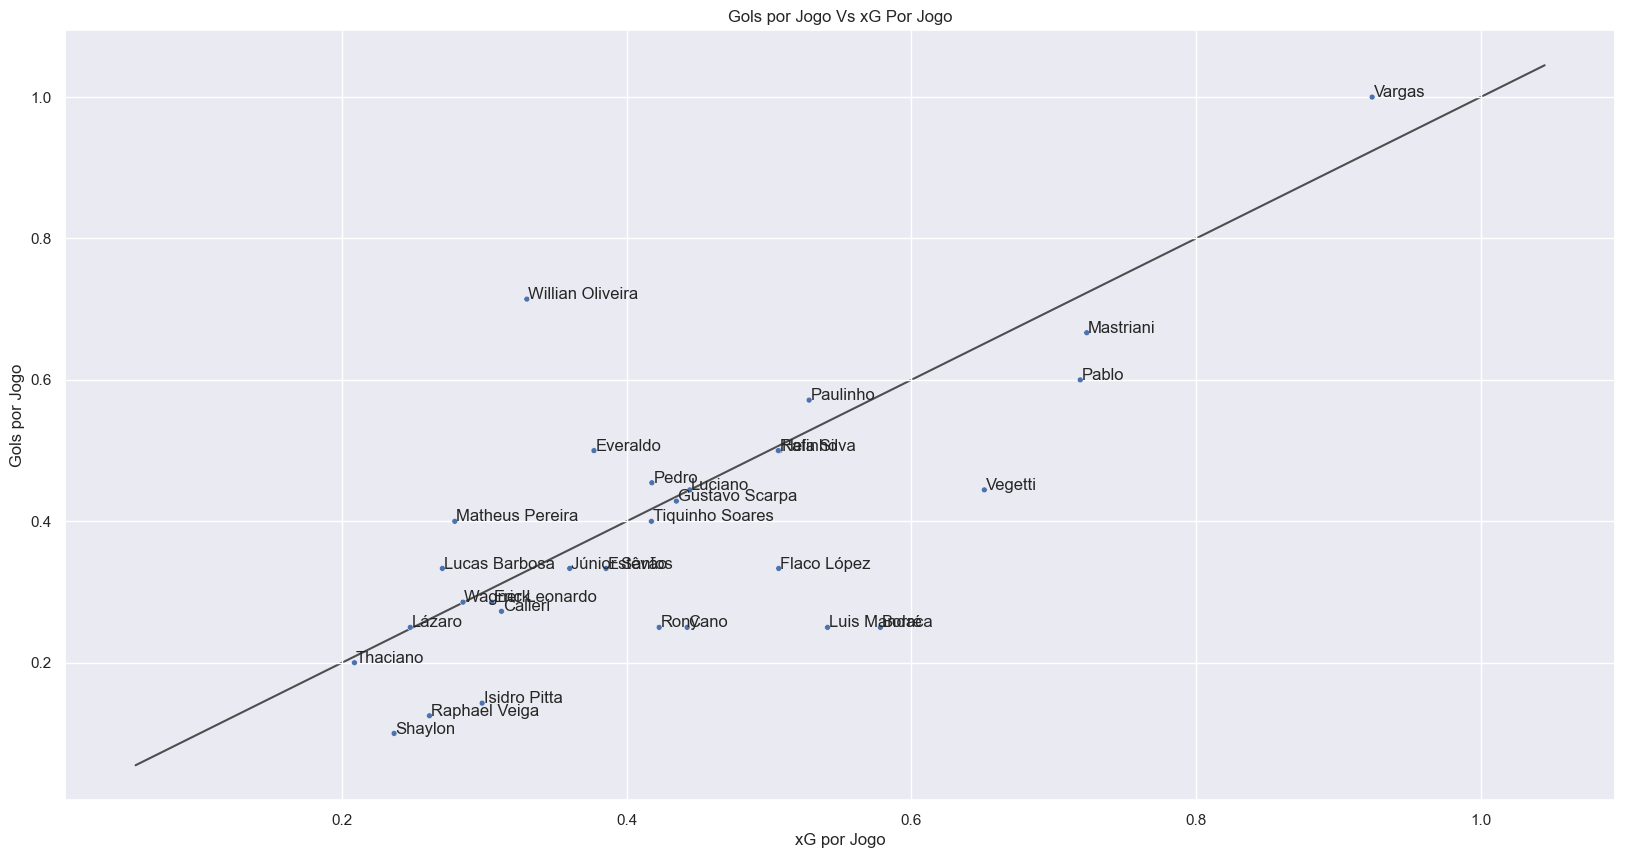

In [639]:
def xG_fit(df, rodada):
    df = df.head(30)  # Limiting the DataFrame to the first 30 entries

    fig, ax = plt.subplots(figsize=(20, 10))

    # Use keyword arguments for clarity
    p1 = sns.scatterplot(x='xG_per_match',  # Horizontal axis
                         y='G_per_match',   # Vertical axis
                         data=df,           # Data source
                         size=8,            # Size of the markers
                         legend=False,      # Disable the legend
                         ax=ax)             # Plot on the created axes

    plt.title('Gols por Jogo Vs xG Por Jogo')
    plt.xlabel('xG por Jogo')
    plt.ylabel('Gols por Jogo')

    # Function to label points on the plot
    def label_point(x, y, val, ax):
        a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
        for i, point in a.iterrows():
            ax.text(point['x'] + .001, point['y'], str(point['val']))

    label_point(df.xG_per_match, df.G_per_match, df.apelido, ax)

    # Adjust plot limits
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # Plot limits against each other to form a line
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

    # Uncomment the next line to save the figure
    # fig.savefig(f'img/G_vs_xG_fit_atletas{rodada}.png')

    plt.show()
    
xG_fit(xg_total,rodada)

## xG per match

In [640]:
rodada = df_brasileiro['rodada_id'].max()
PORCENTAGEM_MINIMA_JOGOS = 2.5  # 40%
min_jogos = rodada // PORCENTAGEM_MINIMA_JOGOS
print(min_jogos)

mask = (xg_total['jogos_num']>=int(min_jogos))
xg_per_match = xg_total.loc[mask]
xg_per_match = xg_per_match.sort_values(by='xG_per_match',ascending=False).reset_index(drop=True)

xg_per_match.head(20)

5.0


,atleta_id,apelido,clube_id,xG_total,shots_total,jogos_num,goals_total,xG_per_match,G_per_match,xG_per_shot,shots_per_goal,clube
0,102561,Mastriani,293,4.339571,16,6,4,0.723262,0.666667,0.271223,4.000000,![Athletico-PR](https://s.glbimg.com/es/sde/f/...
1,69138,Pablo,293,3.593583,13,5,3,0.718717,0.600000,0.276429,4.333333,![Athletico-PR](https://s.glbimg.com/es/sde/f/...
2,99198,Vegetti,267,5.861885,35,9,4,0.651321,0.444444,0.167482,8.750000,![Vasco](https://s.glbimg.com/es/sde/f/organiz...
3,99818,Paulinho,282,3.697590,19,7,4,0.528227,0.571429,0.194610,4.750000,![Atlético-MG](https://s.glbimg.com/es/sde/f/o...
4,102598,Helinho,280,3.045489,17,6,3,0.507582,0.500000,0.179146,5.666667,![Bragantino](https://s.glbimg.com/es/sde/f/or...
5,113103,Flaco López,275,3.041059,13,6,2,0.506843,0.333333,0.233928,6.500000,![Palmeiras](https://s.glbimg.com/es/sde/f/org...
6,80225,Rafa Silva,283,3.039257,9,6,3,0.506543,0.500000,0.337695,3.000000,![Cruzeiro](https://s.sde.globo.com/media/orga...
7,80287,Luciano,276,3.999618,23,9,4,0.444402,0.444444,0.173896,5.750000,![São Paulo](https://s.glbimg.com/es/sde/f/org...
8,79631,Cano,266,3.540117,24,8,2,0.442515,0.250000,0.147505,12.000000,![Fluminense](https://s.glbimg.com/es/sde/f/or...
9,87999,Gustavo Scarpa,282,3.044572,14,7,3,0.434939,0.428571,0.217469,4.666667,![Atlético-MG](https://s.glbimg.com/es/sde/f/o...


In [641]:
xg_per_match = xg_per_match[['apelido','clube','xG_per_match','G_per_match']]
#xg_per_match.head(20).to_csv(f'conteudo/xG_ate_R{rodada}.csv', index=False)



## xG vs Gols

Um estudo comparativo entre Gols e Expected Gols pode ser visto sob dois prismas:

- Eficiência
- Potencial

### 'Eficiência' mede, a partir da diferença entre uma métrica e outra, o nível de aproveitamento dos atletas.

In [642]:
df_atletas2['eficiência'] = df_atletas2['goals_total']-df_atletas2['xG_total']
df_eficiencia = df_atletas2.loc[df_atletas2['goals_total']>=1].sort_values(by='eficiência',ascending=False).reset_index(drop=True).head(50)
df_eficiencia.dropna()

,atleta_id,apelido,clube_id,xG_total,shots_total,jogos_num,goals_total,xG_per_match,G_per_match,xG_per_shot,shots_per_goal,clube,eficiência
0,81952,Willian Oliveira,287,2.309137,11,7,5,0.329877,0.714286,0.209922,2.200000,![Vitória](https://s.sde.globo.com/media/organ...,2.690863
1,105811,Wesley,285,1.565626,27,9,4,0.173958,0.444444,0.057986,6.750000,![Internacional](https://s.glbimg.com/es/sde/f...,2.434374
2,131617,André Silva,276,0.146279,9,6,2,0.024380,0.333333,0.016253,4.500000,![São Paulo](https://s.glbimg.com/es/sde/f/org...,1.853721
3,70958,Jean Carlos,286,1.160232,6,3,3,0.386744,1.000000,0.193372,2.000000,![Juventude](https://s.sde.globo.com/media/org...,1.839768
4,68708,Eduardo,263,0.229786,5,2,2,0.114893,1.000000,0.045957,2.500000,![Botafogo](https://s.glbimg.com/es/sde/f/equi...,1.770214
5,96340,Lima,266,0.254875,10,5,2,0.050975,0.400000,0.025487,5.000000,![Fluminense](https://s.glbimg.com/es/sde/f/or...,1.745125
6,70164,Lucas Moura,276,0.325298,9,5,2,0.065060,0.400000,0.036144,4.500000,![São Paulo](https://s.glbimg.com/es/sde/f/org...,1.674702
7,84674,Lucas Evangelista,280,0.328793,11,6,2,0.054799,0.333333,0.029890,5.500000,![Bragantino](https://s.glbimg.com/es/sde/f/or...,1.671207
8,102928,Canobbio,293,0.427853,10,4,2,0.106963,0.500000,0.042785,5.000000,![Athletico-PR](https://s.glbimg.com/es/sde/f/...,1.572147
9,90715,Luiz Fernando,373,1.449026,22,9,3,0.161003,0.333333,0.065865,7.333333,![Atlético-GO](https://s.sde.globo.com/media/...,1.550974


In [644]:
df_eficiencia = df_eficiencia[['apelido','clube','xG_total','goals_total','xG_per_match','G_per_match','shots_per_goal']]
#df_eficiencia.head(20).to_csv(f'conteudo/Eficiencia_ate_R{rodada}.csv', index=False)
df_eficiencia

,apelido,clube,xG_total,goals_total,xG_per_match,G_per_match,shots_per_goal
0,Willian Oliveira,![Vitória](https://s.sde.globo.com/media/organ...,2.309137,5,0.329877,0.714286,2.200000
1,Wesley,![Internacional](https://s.glbimg.com/es/sde/f...,1.565626,4,0.173958,0.444444,6.750000
2,André Silva,![São Paulo](https://s.glbimg.com/es/sde/f/org...,0.146279,2,0.024380,0.333333,4.500000
3,Jean Carlos,![Juventude](https://s.sde.globo.com/media/org...,1.160232,3,0.386744,1.000000,2.000000
4,Eduardo,![Botafogo](https://s.glbimg.com/es/sde/f/equi...,0.229786,2,0.114893,1.000000,2.500000
5,Lima,![Fluminense](https://s.glbimg.com/es/sde/f/or...,0.254875,2,0.050975,0.400000,5.000000
6,Lucas Moura,![São Paulo](https://s.glbimg.com/es/sde/f/org...,0.325298,2,0.065060,0.400000,4.500000
7,Lucas Evangelista,![Bragantino](https://s.glbimg.com/es/sde/f/or...,0.328793,2,0.054799,0.333333,5.500000
8,Canobbio,![Athletico-PR](https://s.glbimg.com/es/sde/f/...,0.427853,2,0.106963,0.500000,5.000000
9,Luiz Fernando,![Atlético-GO](https://s.sde.globo.com/media/...,1.449026,3,0.161003,0.333333,7.333333


### 'Potencial' mede, por outro lado, aqueles atletas que tem maior potencial de crescimento
Se invertermos o ranking, vemos quem está no topo do aproveitamente abaixo do esperado, ou seja, com maiores possibilidades de convergência para a expectativa

In [645]:
# note: ascending = True
df_potencial = df_atletas2.loc[df_atletas2['goals_total']>=1].head(20).sort_values(by='eficiência',ascending=True).reset_index(drop=True)
df_potencial

,atleta_id,apelido,clube_id,xG_total,shots_total,jogos_num,goals_total,xG_per_match,G_per_match,xG_per_shot,shots_per_goal,clube,eficiência
0,69705,Nikão,293,1.830359,18,7,1,0.261480,0.142857,0.101687,18.000000,![Athletico-PR](https://s.glbimg.com/es/sde/f/...,-0.830359
1,69138,Pablo,293,3.593583,13,5,3,0.718717,0.600000,0.276429,4.333333,![Athletico-PR](https://s.glbimg.com/es/sde/f/...,-0.593583
2,70666,Marllon,1371,1.404827,4,4,1,0.351207,0.250000,0.351207,4.000000,![Cuiabá](https://s.glbimg.com/es/sde/f/organ...,-0.404827
3,38402,Marcelo,266,1.367694,16,6,1,0.227949,0.166667,0.085481,16.000000,![Fluminense](https://s.glbimg.com/es/sde/f/or...,-0.367694
4,70944,Bruno Henrique,285,1.181765,10,6,1,0.196961,0.166667,0.118177,10.000000,![Internacional](https://s.glbimg.com/es/sde/f...,-0.181765
5,72775,Fernandinho,293,1.178049,12,7,1,0.168293,0.142857,0.098171,12.000000,![Athletico-PR](https://s.glbimg.com/es/sde/f/...,-0.178049
6,71684,Gustavo Gómez,275,1.043498,8,5,1,0.208700,0.200000,0.130437,8.000000,![Palmeiras](https://s.glbimg.com/es/sde/f/org...,-0.043498
7,38398,Renato Augusto,266,0.959175,3,3,1,0.319725,0.333333,0.319725,3.000000,![Fluminense](https://s.glbimg.com/es/sde/f/or...,0.040825
8,71227,Maicon,267,0.952783,4,2,1,0.476391,0.500000,0.238196,4.000000,![Vasco](https://s.glbimg.com/es/sde/f/organiz...,0.047217
9,39148,Hulk,282,0.899473,17,6,1,0.149912,0.166667,0.052910,17.000000,![Atlético-MG](https://s.glbimg.com/es/sde/f/o...,0.100527


In [646]:
# def xG_geral(df, row):
#     # Geral
#     conquistado_geral = df[(df['rodada_id']<=row['rodada_id']) & \
#                            (df['clube_id']==row['clube_id'])][['xG']].mean()

#     return conquistado_geral[0]

# def xG_mando_posicao(df, row):
#     # Mandante
#     # Posicao
#     conquistado_mandante_posicao = df[(df['home_dummy']==1) & \
#                                       (df['clube_id']==row['clube_id']) & \
#                                       (df['rodada_id']<=row['rodada_id']) & \
#                                       (df['posicao_id']==row['posicao_id'])][['xG']].mean()
#     # Geral
#     conquistado_mandante_geral = df[(df['home_dummy']==1) & \
#                                     (df['rodada_id']<=row['rodada_id']) & \
#                                     (df['clube_id']==row['clube_id'])][['xG']].mean()
#     # Visitante
#     # Posicao
#     conquistado_visitante_posicao = df[(df['home_dummy']==0) & \
#                                        (df['clube_id']==row['clube_id']) & \
#                                        (df['rodada_id']<=row['rodada_id']) & \
#                                        (df['posicao_id']==row['posicao_id'])][['xG']].mean()
#     # Geral
#     conquistado_visitante_geral = df[(df['home_dummy']==0) & \
#                                      (df['rodada_id']<=row['rodada_id']) & \
#                                      (df['clube_id']==row['clube_id'])][['xG']].mean()

#     return conquistado_mandante_posicao[0], conquistado_mandante_geral[0], conquistado_visitante_posicao[0], conquistado_visitante_geral[0]

# # xG allowed
# def xGA_mando_posicao(df, row):
#     # Mandante
#     # Posicao
#     cedido_mandante_posicao = df[(df['home_dummy']==0) & \
#                                  (df['adversario_id']==row['equipe_id']) & \
#                                  (df['rodada_id']<=row['rodada_id']) & \
#                                  (df['posicao_id']==row['posicao_id'])][['xG']].mean()
#     # Geral
#     cedido_mandante_geral = df[(df['home_dummy']==0) & \
#                                (df['rodada_id']<=row['rodada_id']) & \
#                                (df['adversario_id']==row['equipe_id'])][['xG']].mean()

#     # Visitante
#     # Posicao
#     cedido_visitante_posicao = df[(df['home_dummy']==1) & \
#                                   (df['adversario_id']==row['equipe_id']) & \
#                                   (df['rodada_id']<=row['rodada_id']) & \
#                                   (df['posicao_id']==row['posicao_id'])][['xG']].mean()
#     # Geral
#     cedido_visitante_geral = df[(df['home_dummy']==1) & \
#                                 (df['rodada_id']<=row['rodada_id']) & \
#                                 (df['adversario_id']==row['equipe_id'])][['xG']].mean()


#     return cedido_mandante_posicao[0], cedido_mandante_geral[0], cedido_visitante_posicao[0], cedido_visitante_geral[0]

# df_brasileiro['xg_mando_pos'] = df_brasileiro.apply(lambda x: xG_mando_posicao(df_brasileiro, x))
# #print (df_brasileiro.query('rodada_id >= 1')[('sum', 'xG')].mean())